In [1]:
import pandas as pd
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm

from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate
from sklearn.preprocessing import MinMaxScaler

from IPython.display import clear_output
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

c:\Users\jaden\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\jaden\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\jaden\AppData\Local\Programs\Python\Python311\L

In [2]:
application_train = pd.read_csv('input/application_train.csv')
application_test = pd.read_csv('input/application_test.csv')

To re-create the the original author's model as closely as possible, we replicate the same data processing process as the author did. The only difference is that we split the training set into a training and validation set because we cannot test the accuracy of our model when the test set does not contain TARGET.

In [94]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

train_labels = application_train['TARGET']
# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

(307511, 240)
0 columns were label encoded.
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)
(307511, 240)
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [5]:
#because the prediction are non-binary numbers ranging from 0 to 1, we need to find the optimal threshold for the prediction
#using the f1 score as the metric
def get_optimal_threshold(y_val, log_reg_pred):
    thresholds = np.arange(0.01, 1, 0.01)
    f1 = [f1_score(y_val, (log_reg_pred > t).astype(int)) for t in thresholds]
    optimal = np.argmax(f1)
    return thresholds[optimal]
#for Non-binary columns like AMT_INCOME_TOTAL, we need to find the right threshold to categorize the data into 2 groups
def get_feature_threshold(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return q3+1.5*iqr


In [87]:
def get_log_model_metrics(sensitiveFeature, binary, train, val, y_val, y_train, column_names, categories):
    # Store sensitive features and drop the column from train and val
    print(sensitiveFeature)
    sensitive_feature_train = train[sensitiveFeature[0]]
    sensitive_feature_val = val[sensitiveFeature[0]]

    if binary==False:
        feature_threshold = get_feature_threshold(sensitive_feature_val)
        print(feature_threshold)
        sensitive_feature_val = (sensitive_feature_val > feature_threshold).astype(int)
    else:
        label_encoder = LabelEncoder()
        label_encoder.fit(sensitive_feature_train)
        sensitive_feature_train = label_encoder.transform(sensitive_feature_train)
        sensitive_feature_val = label_encoder.transform(sensitive_feature_val)


    train = train.drop(columns=sensitiveFeature)
    val = val.drop(columns=sensitiveFeature)

    # Median imputation of missing values
    imputer = SimpleImputer(strategy='median')
    imputer.fit(train)
    train = imputer.transform(train)
    val = imputer.transform(val)

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train)
    train = scaler.transform(train)
    val = scaler.transform(val)

    # Train the logistic regression model
    log_reg = LogisticRegression(C=0.0001)
    log_reg.fit(train, y_train)

    # Make predictions
    log_reg_pred = log_reg.predict_proba(val)[:, 1]
    optimal = get_optimal_threshold(y_val, log_reg_pred)
    y_val_pred = (log_reg_pred > optimal).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)

    metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }
    
    grouped = MetricFrame(metrics=metrics,
                             y_true=y_val,
                             y_pred=y_val_pred,
                             sensitive_features=sensitive_feature_val)
    grouped.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by "+ sensitiveFeature[0],
    )
    plt.xticks(ticks=range(len(categories)), labels=categories)  # for x-axis categories


    plt.show()

    demo_parity_diff = demographic_parity_difference(y_val, y_val_pred, sensitive_features=sensitive_feature_val)
    demo_parity_ratio = demographic_parity_ratio(y_val, y_val_pred, sensitive_features=sensitive_feature_val)

    column_names = [col for col in column_names if (col != 'TARGET' and col != 'SK_ID_CURR' and col not in sensitiveFeature)]
    column_names

    print('ACCURACY: ', accuracy)
    print('DEMOGRAPHIC PARITY DIFFERENCE: ', demo_parity_diff)
    print('DEMOGRAPHIC PARITY RATIO: ', demo_parity_ratio)

    val = pd.DataFrame(val, columns=column_names)
    val_sample = val.sample(n=500, random_state=42)  # Select a random subset of 100 instances

    explainer = shap.LinearExplainer(log_reg, val_sample)
    plt.figure(figsize=(3, 2))
    shap_values = explainer.shap_values(val_sample)
    shap.summary_plot(shap_values, val_sample, plot_type="bar")
    shap.summary_plot(shap_values, val_sample)
    plt.show()


In [35]:
train['NAME']


89205     False
105785    False
32130     False
260459    False
56076      True
          ...  
119879    False
259178    False
131932     True
146867    False
121958     True
Name: NAME_EDUCATION_TYPE_Higher education, Length: 184506, dtype: bool

In [114]:
# Split the dataset into train and validation sets


train, val = train_test_split(application_train, test_size=0.4, random_state=42)
column_names = application_train.columns
    
# Extract the TARGET column as the target variable
y_train = train['TARGET']
y_val = val['TARGET']

# Drop the TARGET column from the train and val sets
train = train.drop(columns=['TARGET'])
val = val.drop(columns=['TARGET'])

# Separate the ID column
train = train.drop(columns=['SK_ID_CURR'])
val = val.drop(columns=['SK_ID_CURR'])

# Find sensitive features
#For features like CODE_GENDER_F that have a counterpart CODE_GENDER_M, we remove both features
Children = {'CNT_CHILDREN': [['CNT_CHILDREN'],['No Children', 'Has Children']]}
Credit = {'AMT_INCOME_TOTAL': [['AMT_INCOME_TOTAL'],['Low Income', 'High Income']], 'AMT_CREDIT': [['AMT_CREDIT'],['Low Credit', 'High Credit']]}
Ownership = {'FLAG_OWN_CAR': [['FLAG_OWN_CAR'],['No Car', 'Own Car']], 'FLAG_OWN_REALTY': [['FLAG_OWN_REALTY'],['No Property', 'Own Property']]}
Gender = {'CODE_GENDER_F': [['CODE_GENDER_F', 'CODE_GENDER_M'],['Male', 'Female']]}
Education = {'NAME_EDUCATION_TYPE_Higher education': [['NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Academic degree'],['No Higher Education', 'Higher Education']], 'NAME_EDUCATION_TYPE_Secondary / secondary special': [['NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Academic degree'],['No Secondary Education', 'Secondary Education']]}
Family = {'NAME_FAMILY_STATUS_Married': [['NAME_FAMILY_STATUS_Married'],['Not Married', 'Married']]}
Working = {'NAME_INCOME_TYPE_Working': [['NAME_INCOME_TYPE_Working', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman'],['Not Working', 'Working']], 
           'NAME_INCOME_TYPE_Commercial associate':[['NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman'],['Not Commercial Associate', 'Commercial Associate']], 
           'NAME_INCOME_TYPE_Pensioner' :[['NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman'],['Not State Servent', 'State Servnet']]}


In [111]:
train['NAME_INCOME_TYPE_Commercial associate'].value_counts()

NAME_INCOME_TYPE_Commercial associate
False    141605
True      42901
Name: count, dtype: int64

We start by examining the metrics of the logistic regression model based on marriage status. 

['NAME_FAMILY_STATUS_Married']


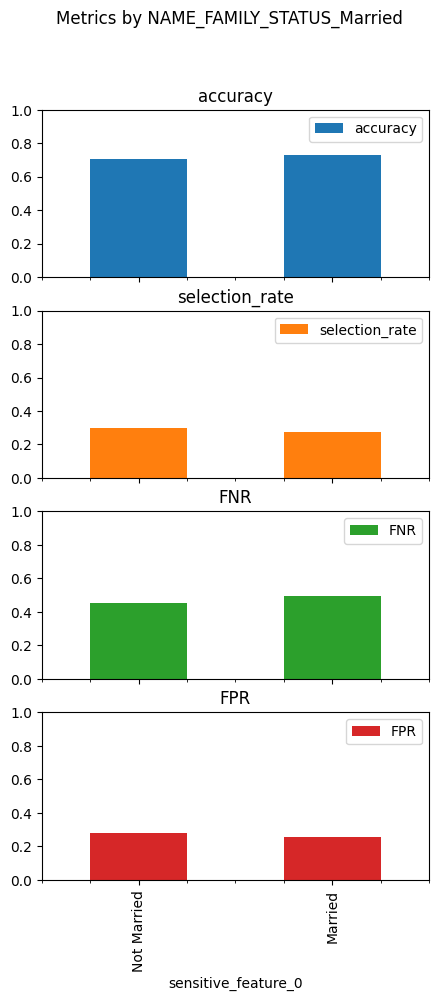

ACCURACY:  0.7198813056379822
DEMOGRAPHIC PARITY DIFFERENCE:  0.027232670647136414
DEMOGRAPHIC PARITY RATIO:  0.9094966500732191


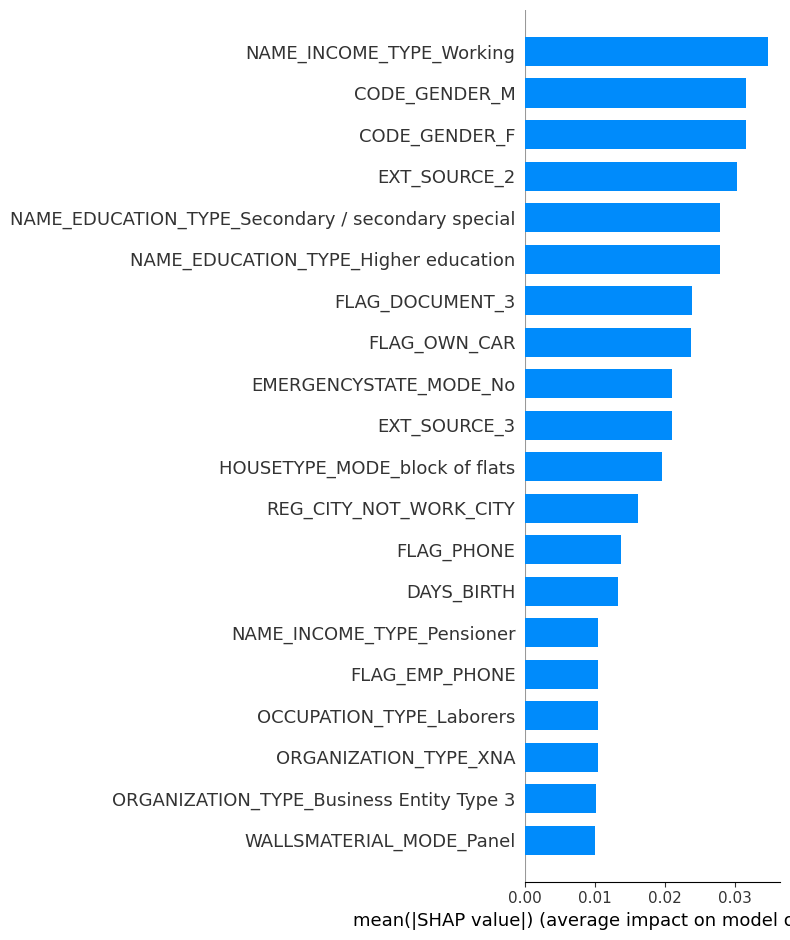

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


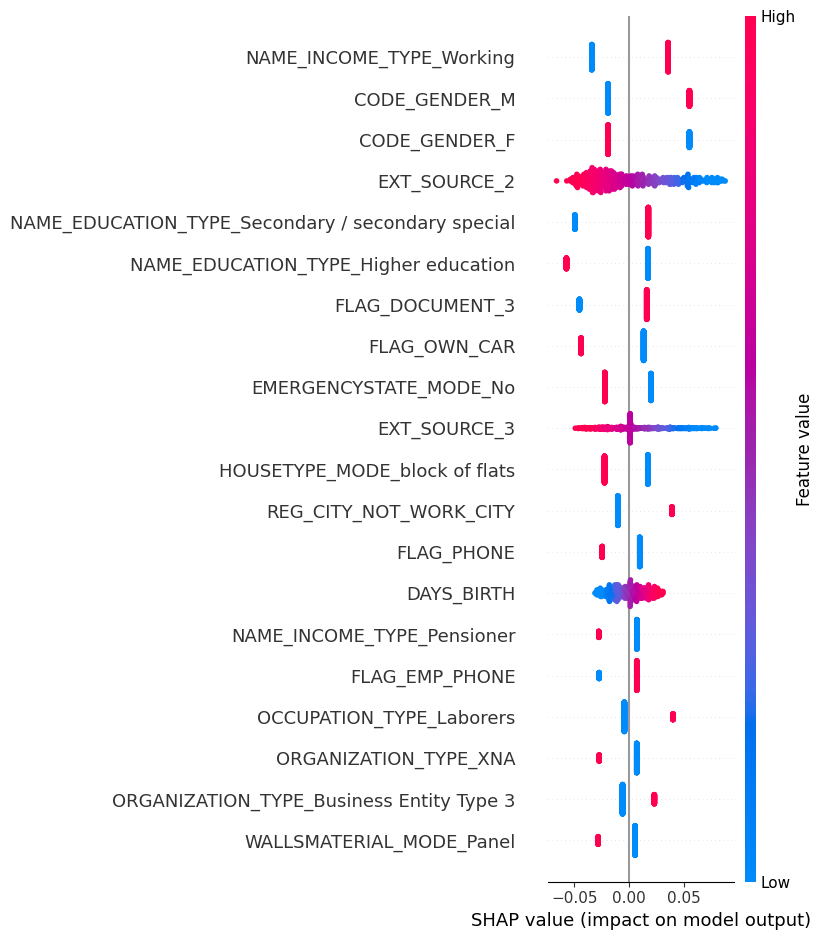

['CNT_CHILDREN']


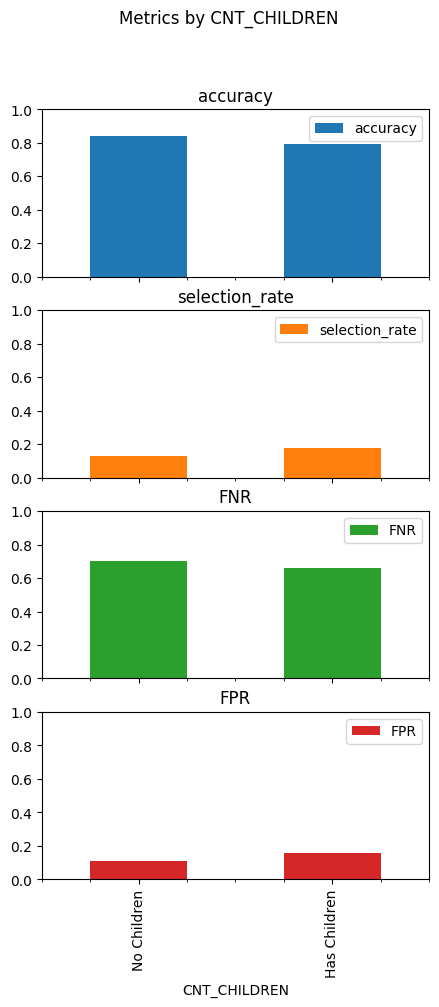

ACCURACY:  0.8397788707776107
DEMOGRAPHIC PARITY DIFFERENCE:  0.049930213281324354
DEMOGRAPHIC PARITY RATIO:  0.718458023174984


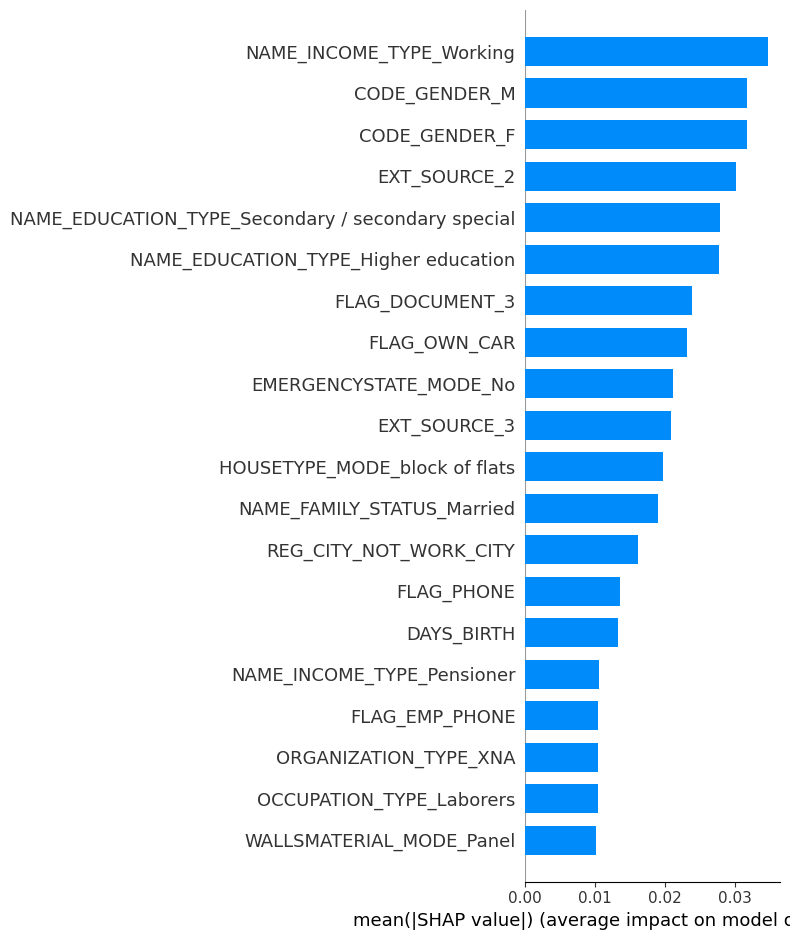

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


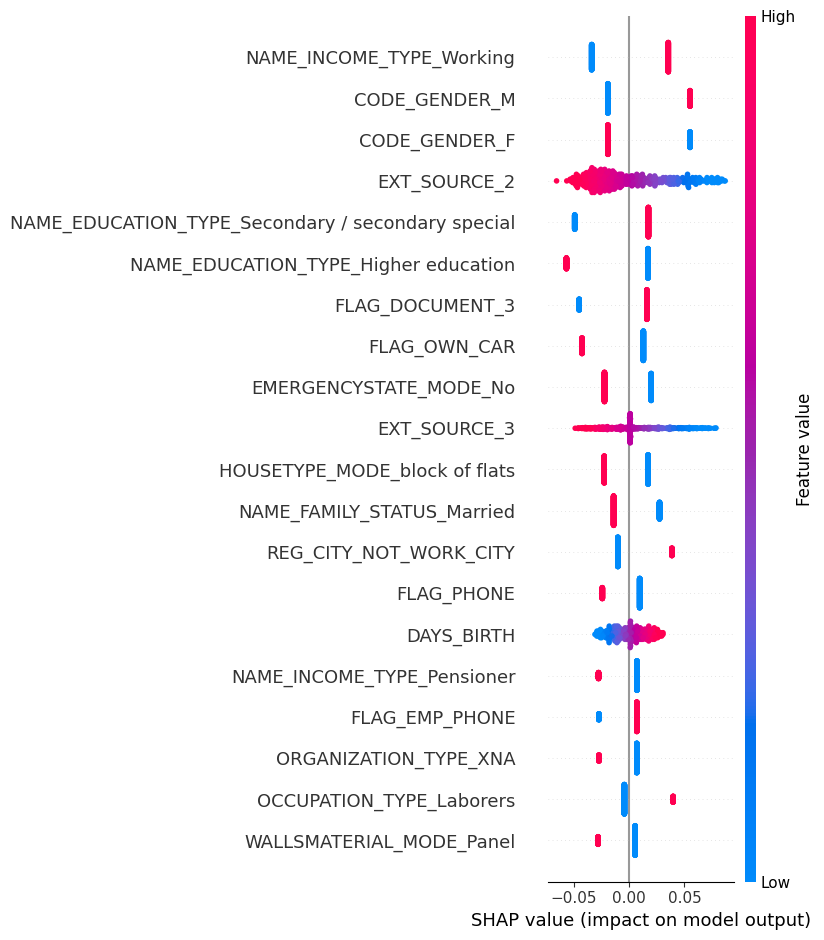

In [83]:
#set family as sensitive feature
for category, value in Family.items():
    get_log_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

#set children as sensitive feature
for category, value in Children.items():
    get_log_model_metrics(value[0], False, train, val, y_val, y_train, column_names, value[1]) 

We see that the logistic model performs fairly well with marriage status as a sensitive attribute. We observe a demographic parity ratio of 0.909, FPR and FNR between the groups are also similar. However, if someone has children makes more of an impact. We observe an demographic parity ratio of 0.718. Now, we examine gender as a sensitive attribute.

In [69]:
train.to_csv('train.csv')

['CODE_GENDER_F', 'CODE_GENDER_M']


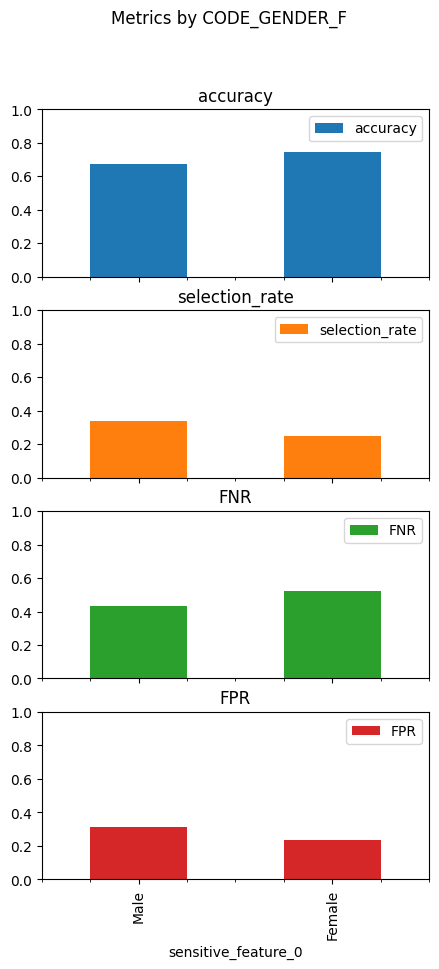

ACCURACY:  0.7214584772976709
DEMOGRAPHIC PARITY DIFFERENCE:  0.09038569660472434
DEMOGRAPHIC PARITY RATIO:  0.7346219171476546


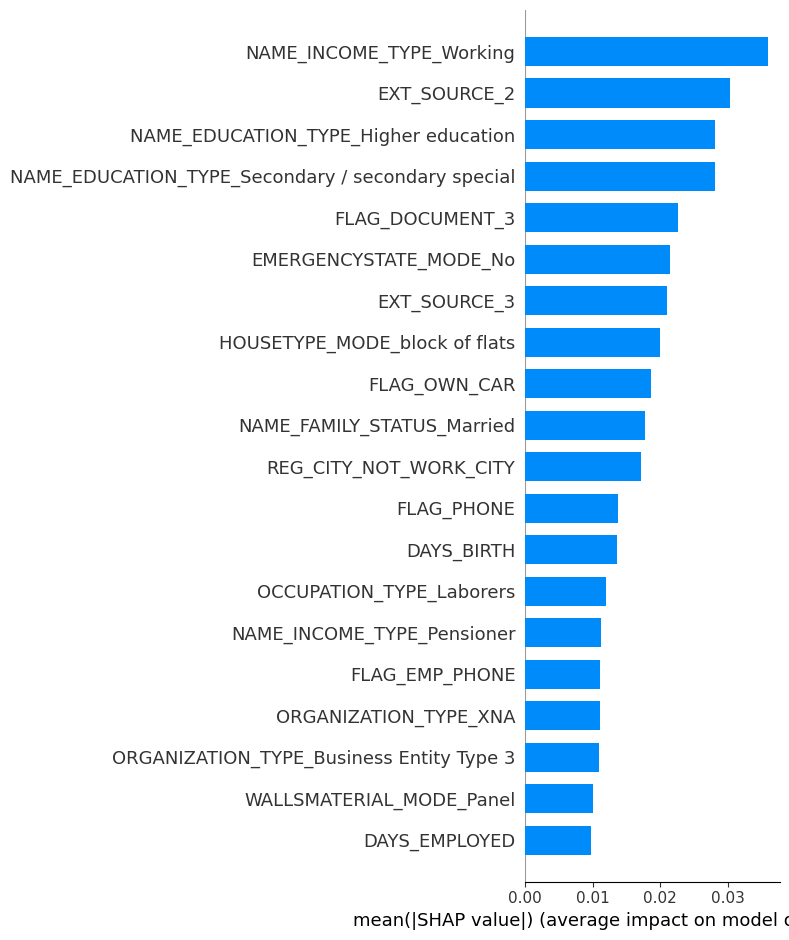

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


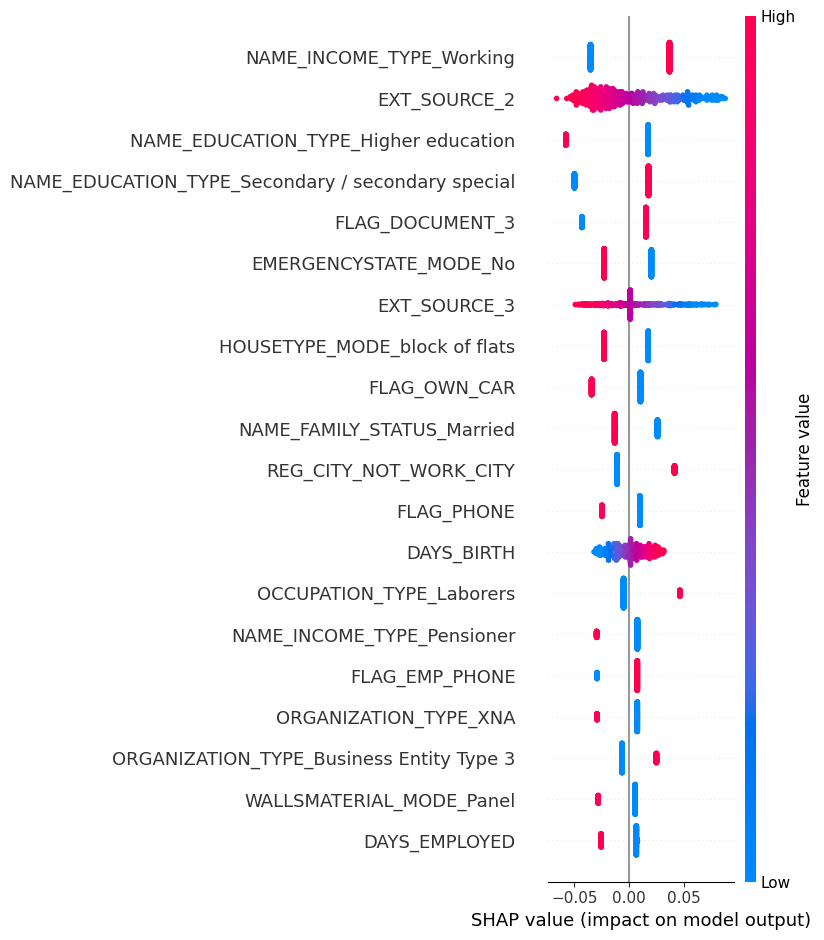

In [76]:
for category, value in Gender.items():
    get_log_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

Compared to marriage status, setting gender as the sensitive attribute results in a lower demographic parity ratio. As shown in the graph, FPR for male is higher than female, and the FNR is higher female than male. This clearly benefits males as they are more likely to be approved for a loan.

Now, we evaluate education as a sensitive attribute.

['NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Academic degree']


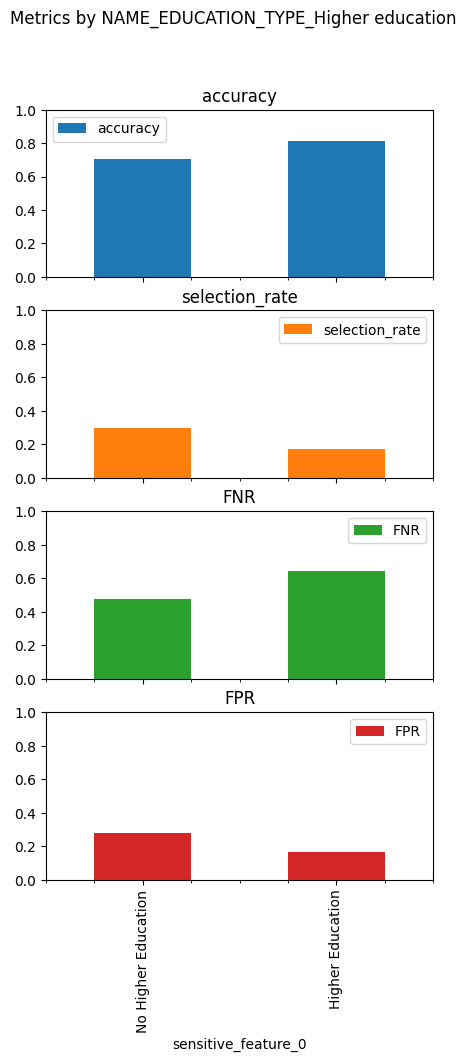

ACCURACY:  0.7305231494654689
DEMOGRAPHIC PARITY DIFFERENCE:  0.12352131109467232
DEMOGRAPHIC PARITY RATIO:  0.5864171720947318


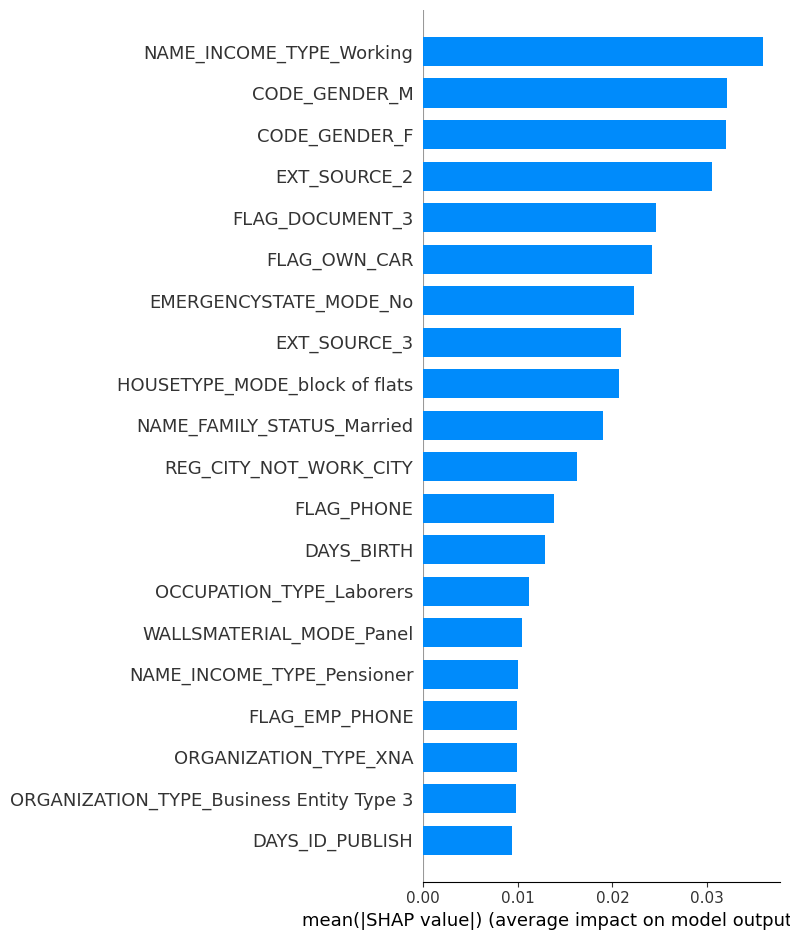

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


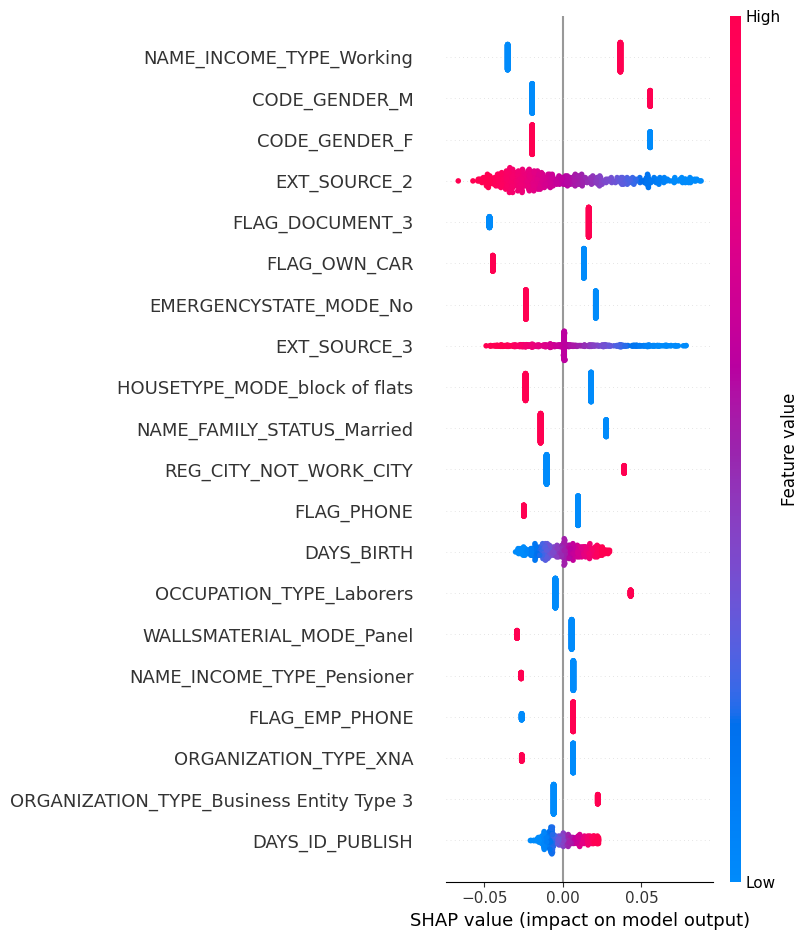

['NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Academic degree']


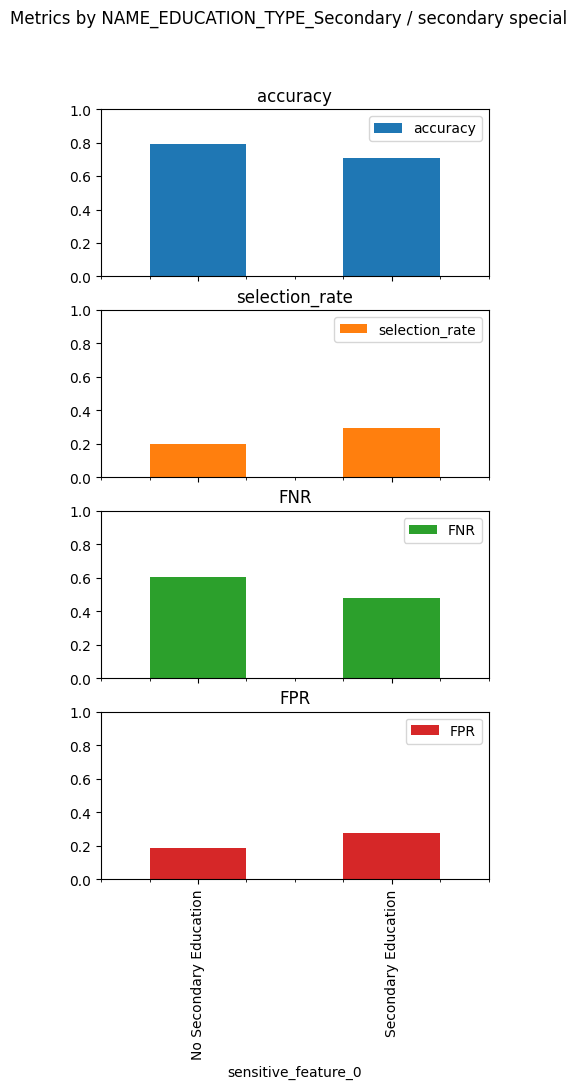

ACCURACY:  0.7305231494654689
DEMOGRAPHIC PARITY DIFFERENCE:  0.09819207354514481
DEMOGRAPHIC PARITY RATIO:  0.669529054218408


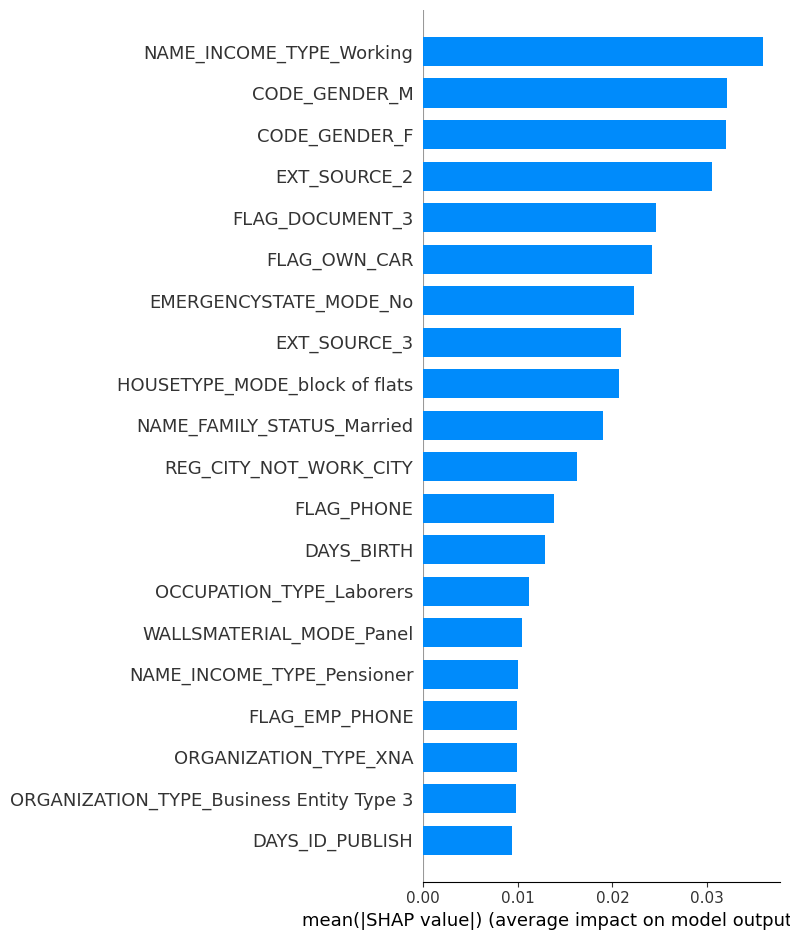

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


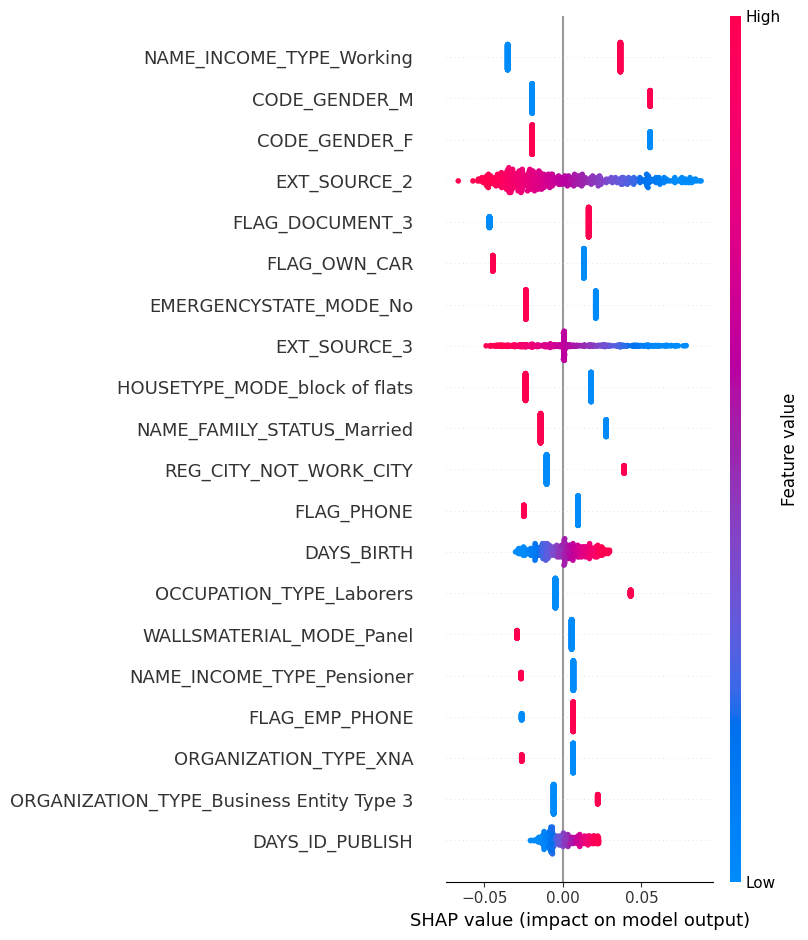

In [79]:
for category, value in Education.items():
    get_log_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

We see that the model is biased towards the education level. However, based on selection rate and false predictions, we find it odd that the bank favors those who have received secondary education but doesn't seem to favor those who have received higher education. 

Now, we want to examine financial status as a sensitive attribute. To do that, we seperately test property ownership, income, and credit score to see if they are biased.

['AMT_INCOME_TOTAL']
337500.0


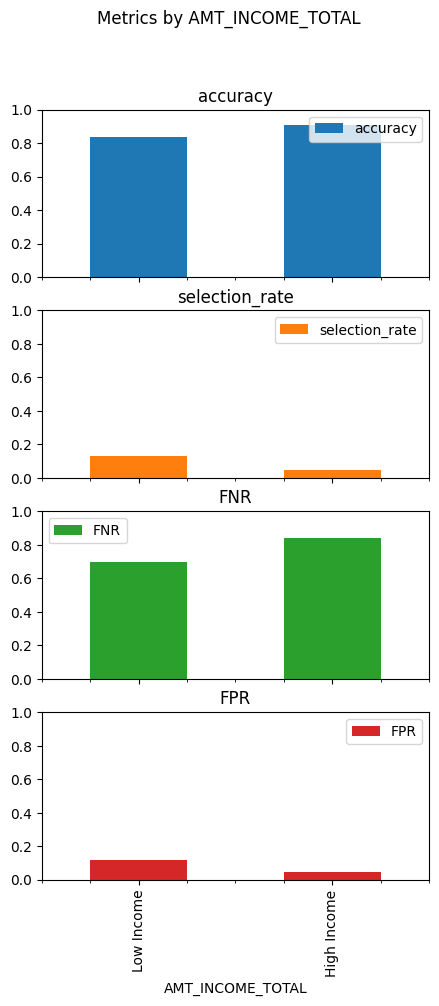

ACCURACY:  0.8397951302792569
DEMOGRAPHIC PARITY DIFFERENCE:  0.08205840626161193
DEMOGRAPHIC PARITY RATIO:  0.37769504099657486


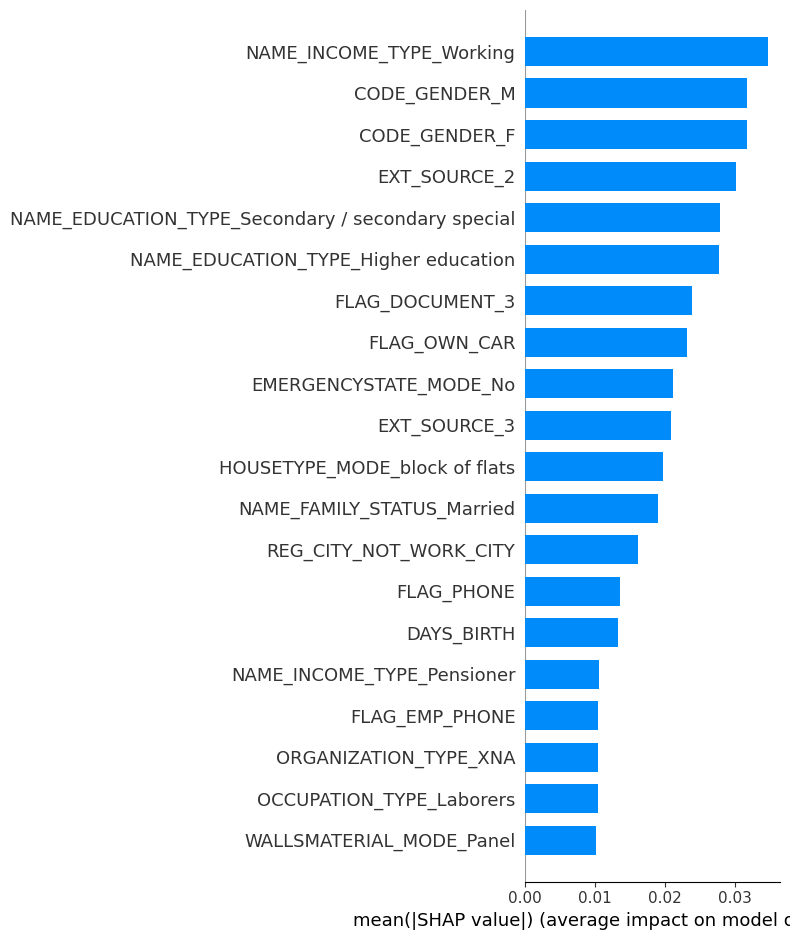

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


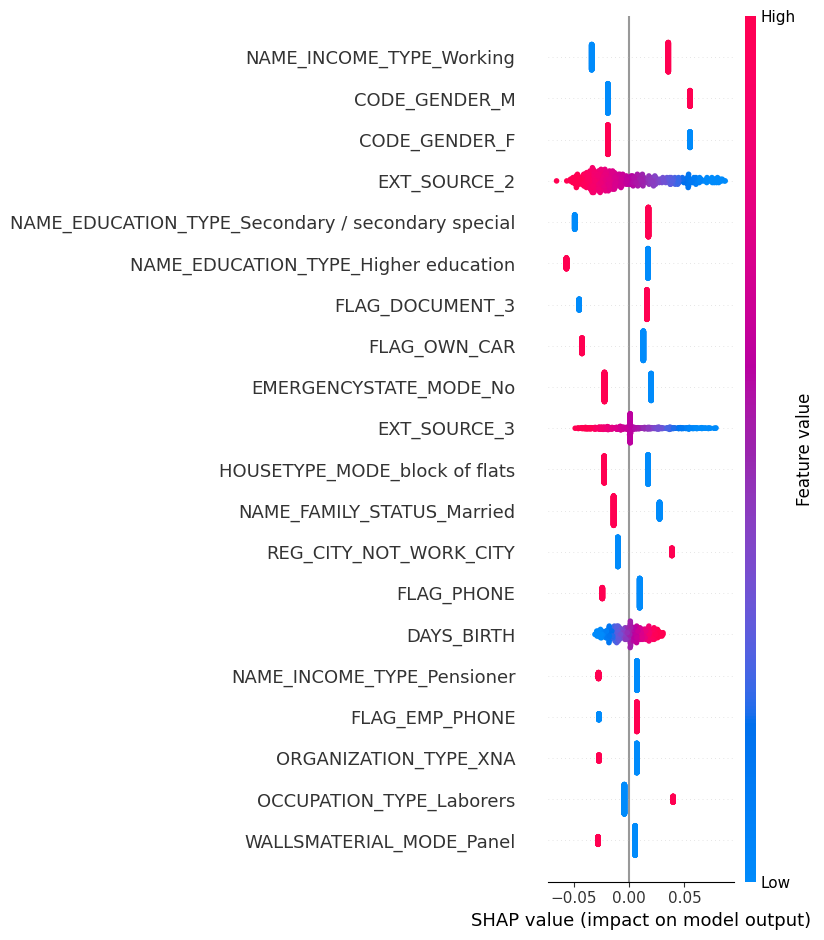

['AMT_CREDIT']
1616625.0


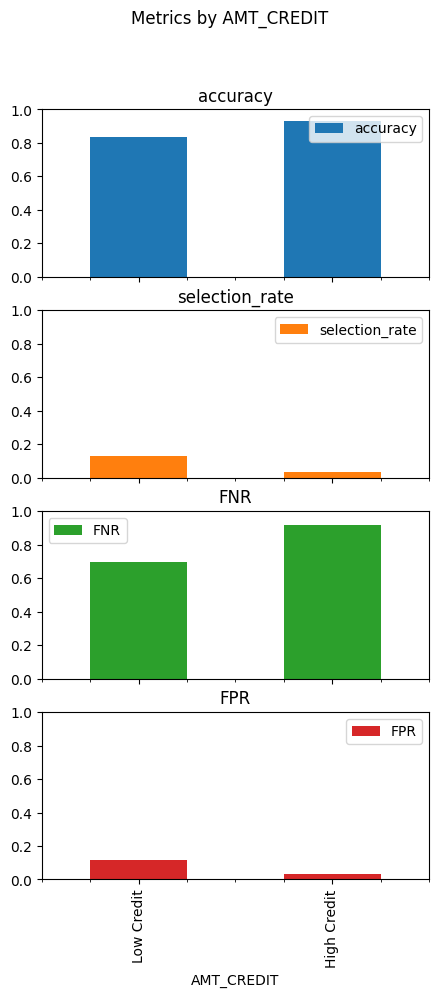

ACCURACY:  0.8398195195317264
DEMOGRAPHIC PARITY DIFFERENCE:  0.09653055615863794
DEMOGRAPHIC PARITY RATIO:  0.2584252998926512


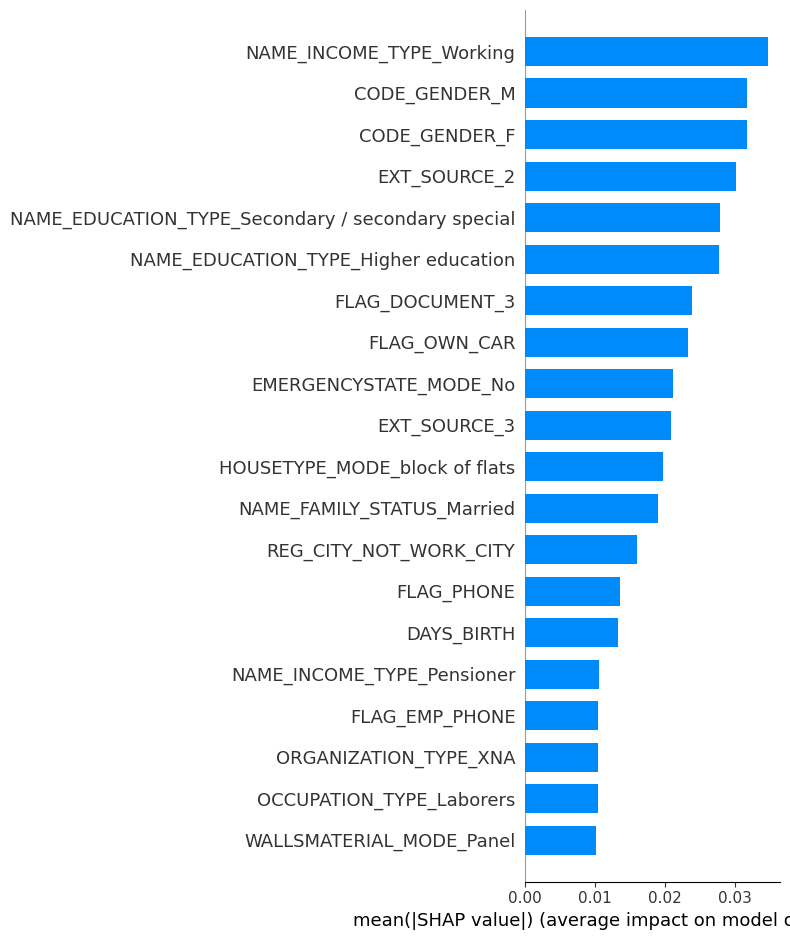

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


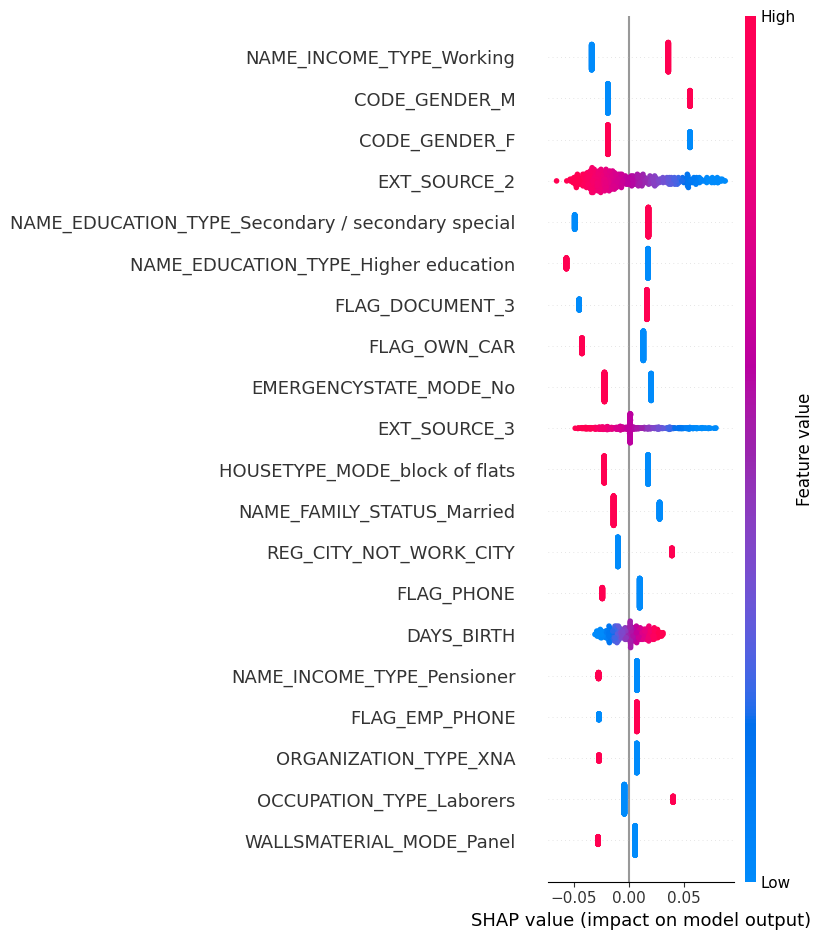

['FLAG_OWN_CAR']


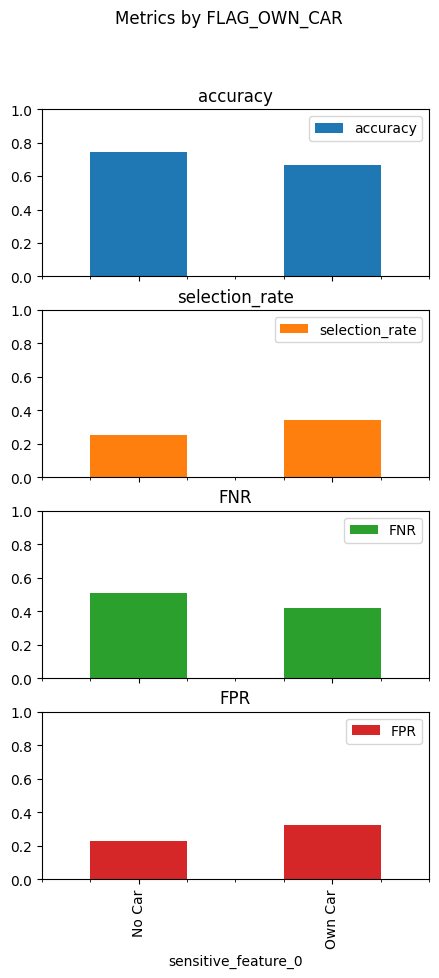

ACCURACY:  0.7197268403723426
DEMOGRAPHIC PARITY DIFFERENCE:  0.09254824471444101
DEMOGRAPHIC PARITY RATIO:  0.7310991671043306


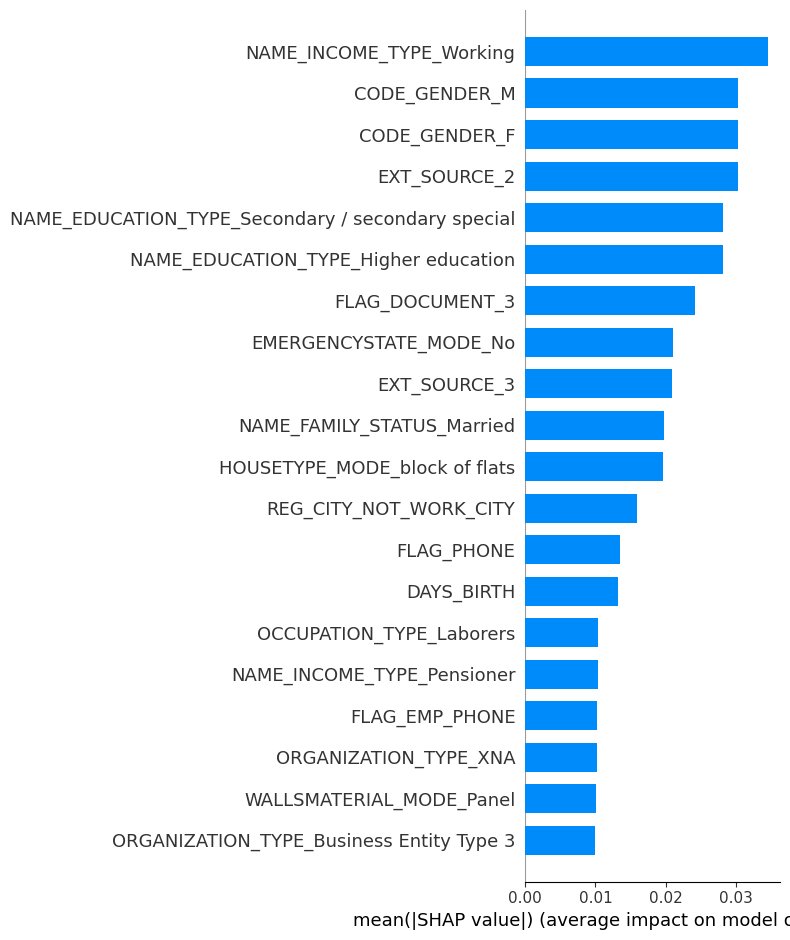

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


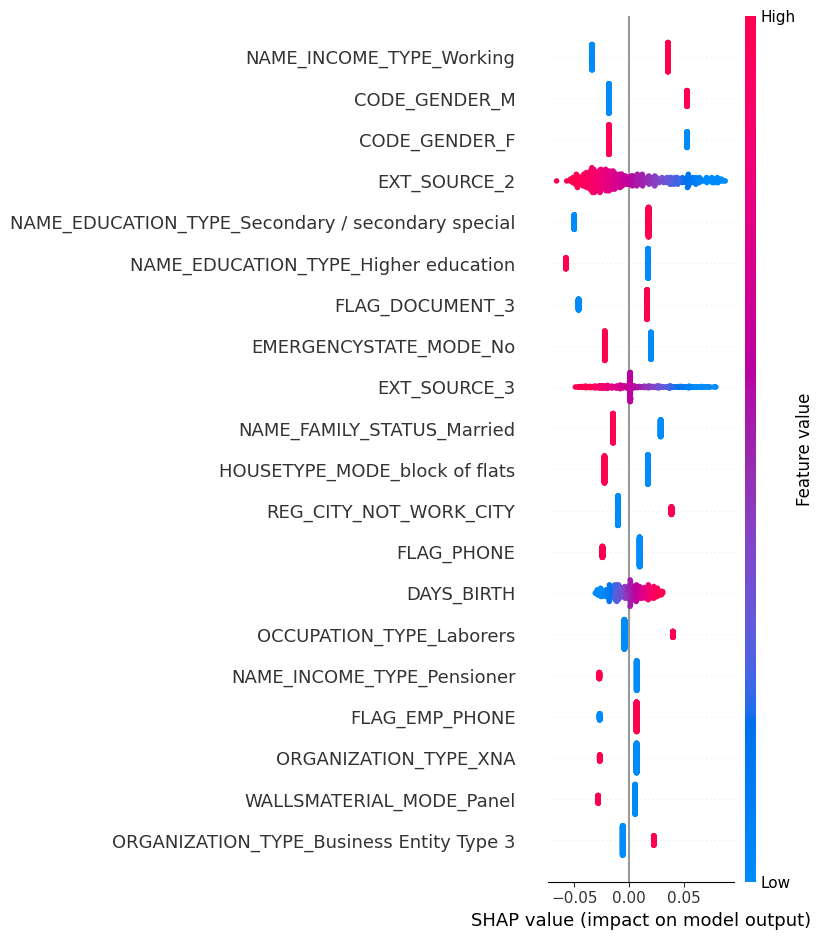

['FLAG_OWN_REALTY']


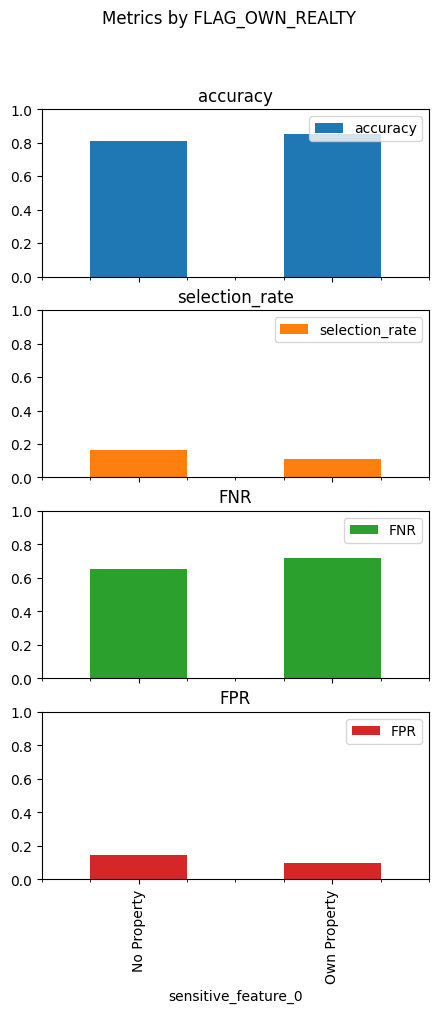

ACCURACY:  0.8397788707776107
DEMOGRAPHIC PARITY DIFFERENCE:  0.048663892837010475
DEMOGRAPHIC PARITY RATIO:  0.6992508016949186


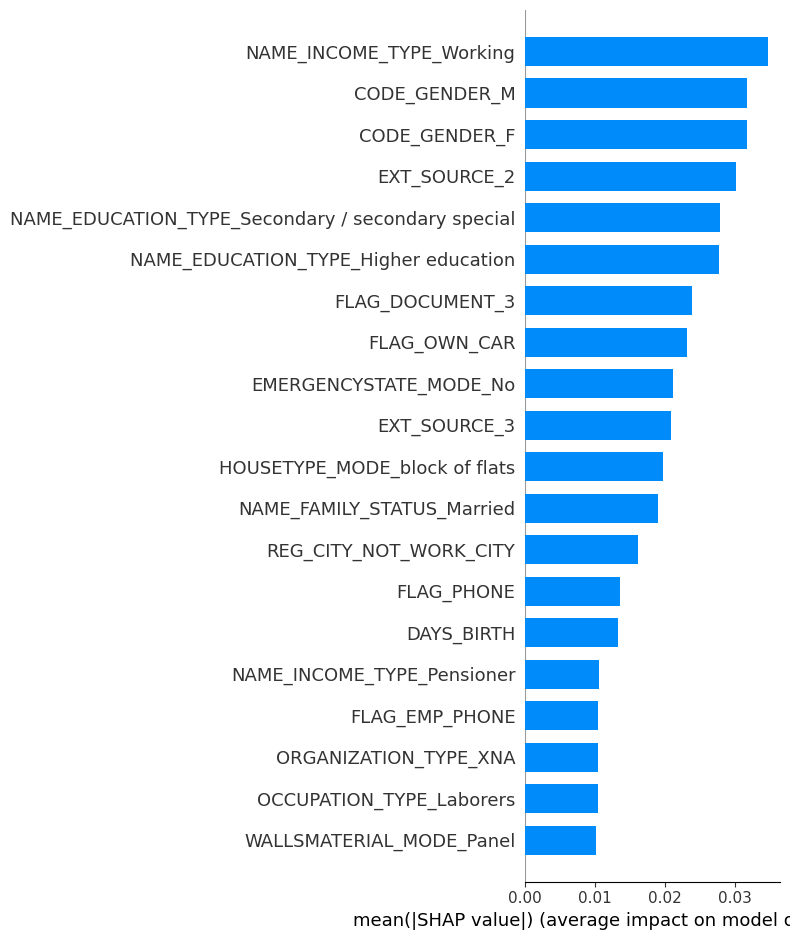

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


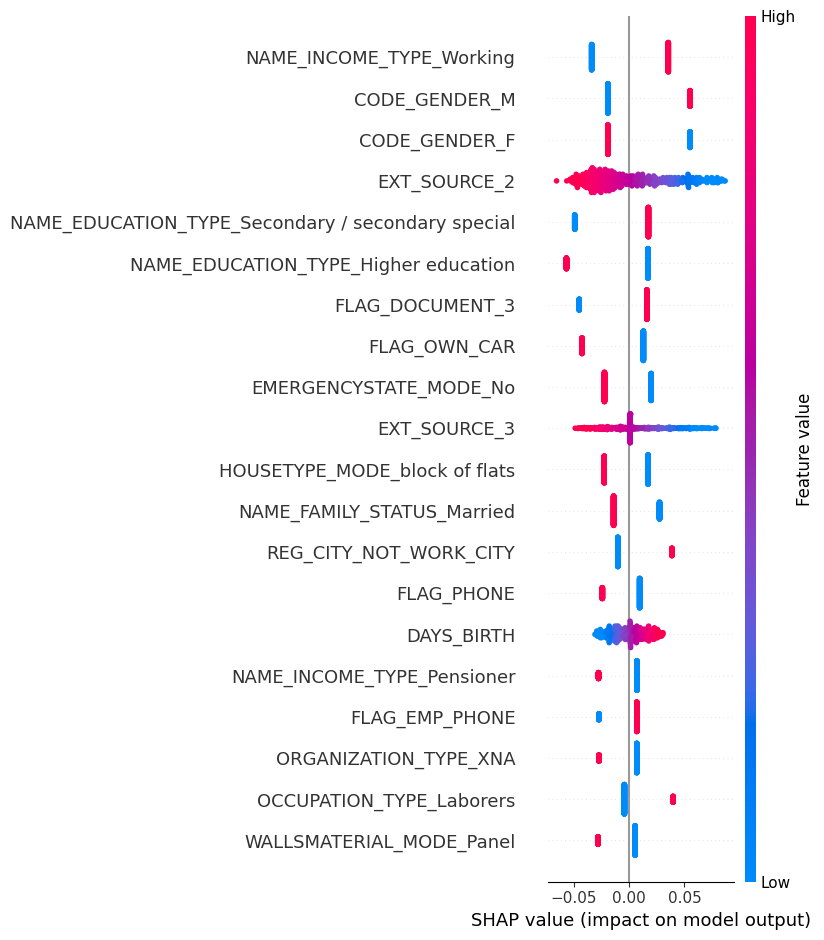

In [88]:
for category, value in Credit.items():
    get_log_model_metrics(value[0], False, train, val, y_val, y_train, column_names, value[1])

for category, value in Ownership.items():
    get_log_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

Now to evaluate income type and check if a specific occupation is favored. We assess all different types of occupation except for student, unemployed, and business owner because they only appear in the training set less than 10 times.

['NAME_INCOME_TYPE_Working', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman']


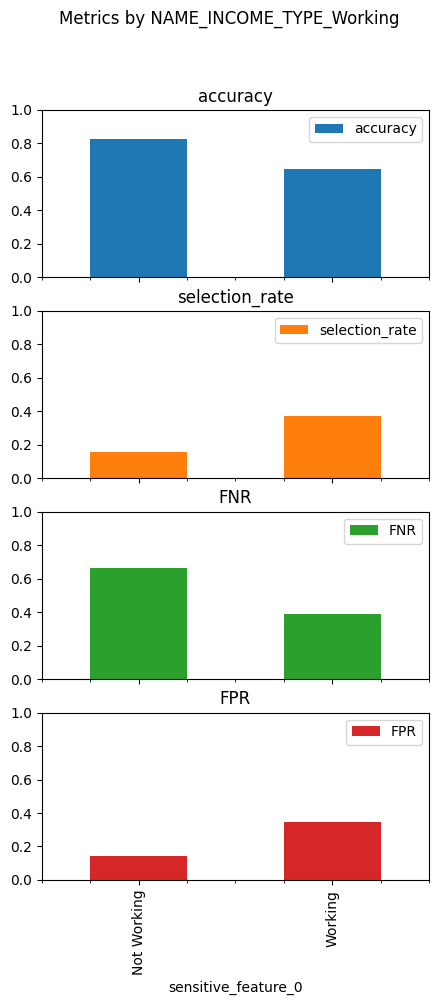

ACCURACY:  0.7331409292305191
DEMOGRAPHIC PARITY DIFFERENCE:  0.2169647531715259
DEMOGRAPHIC PARITY RATIO:  0.41738752582403


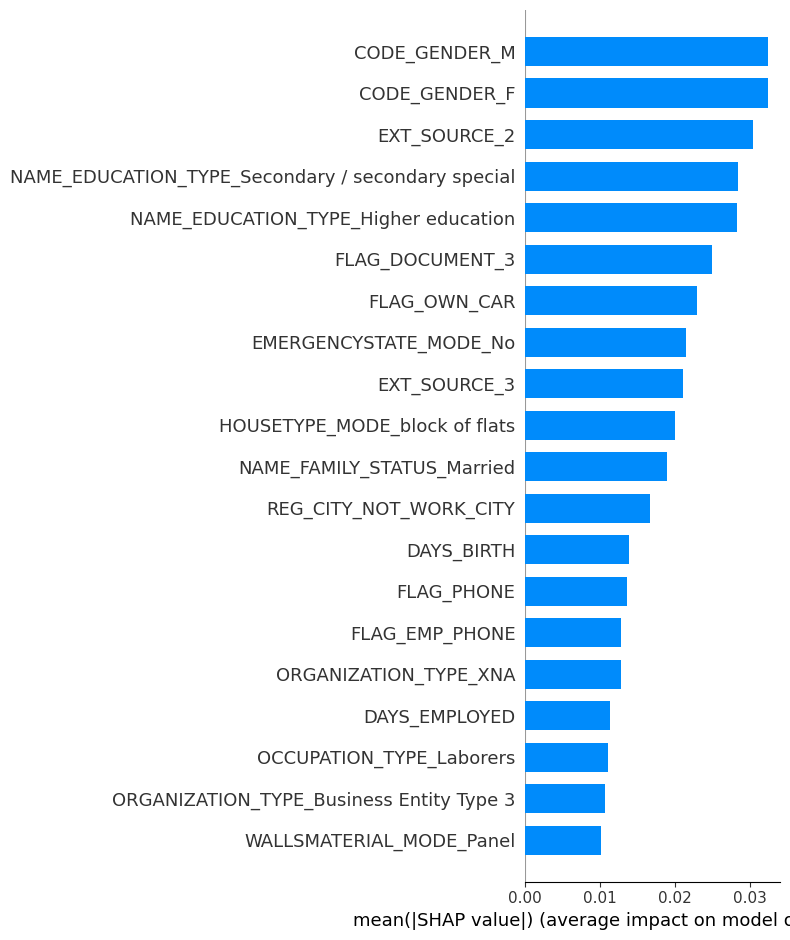

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


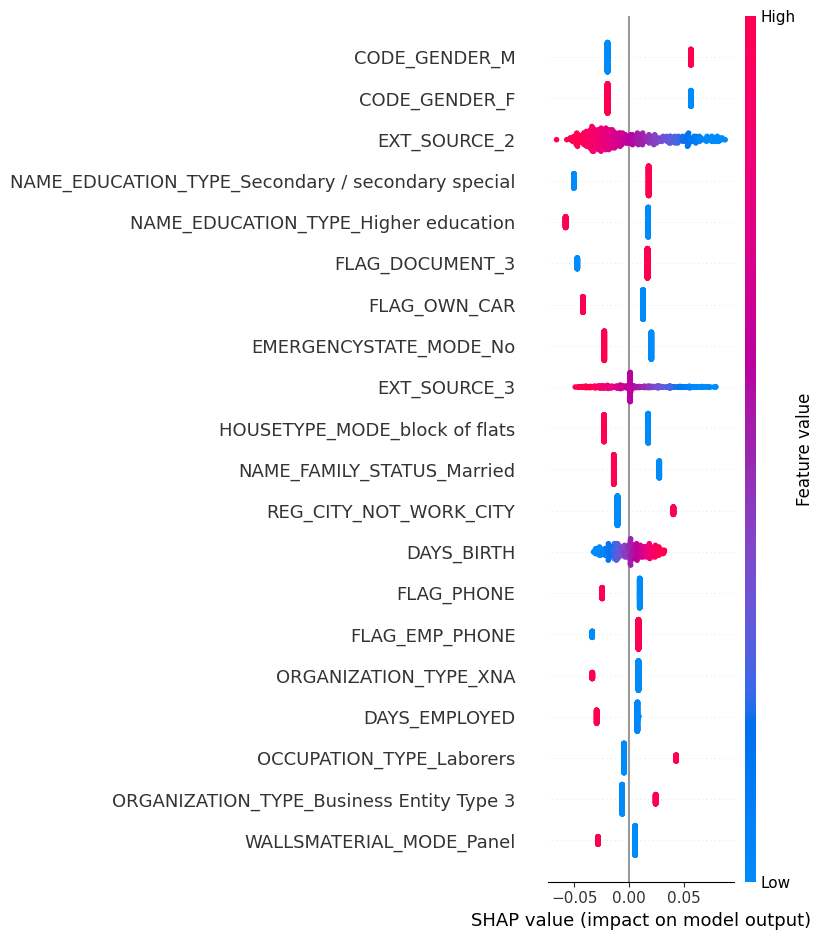

['NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman']


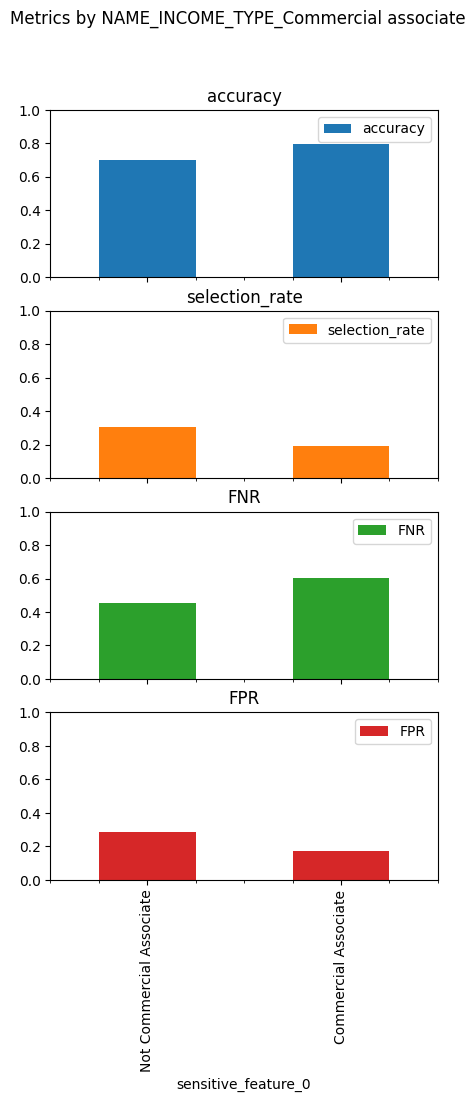

ACCURACY:  0.7239705703020203
DEMOGRAPHIC PARITY DIFFERENCE:  0.11539226569397809
DEMOGRAPHIC PARITY RATIO:  0.6221489376621114


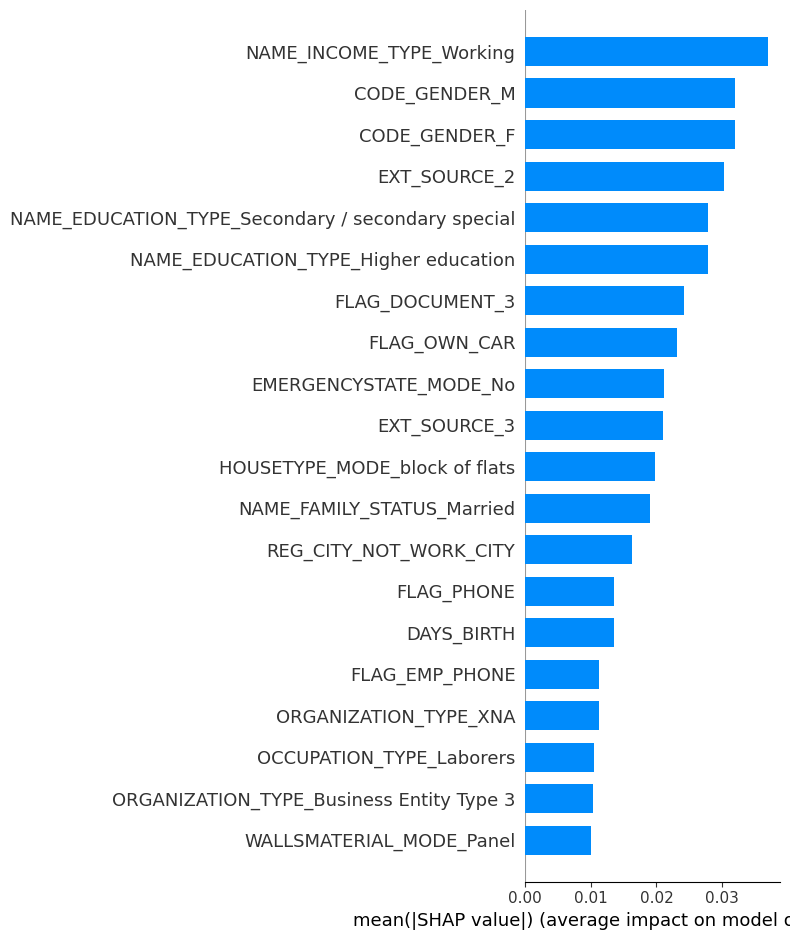

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


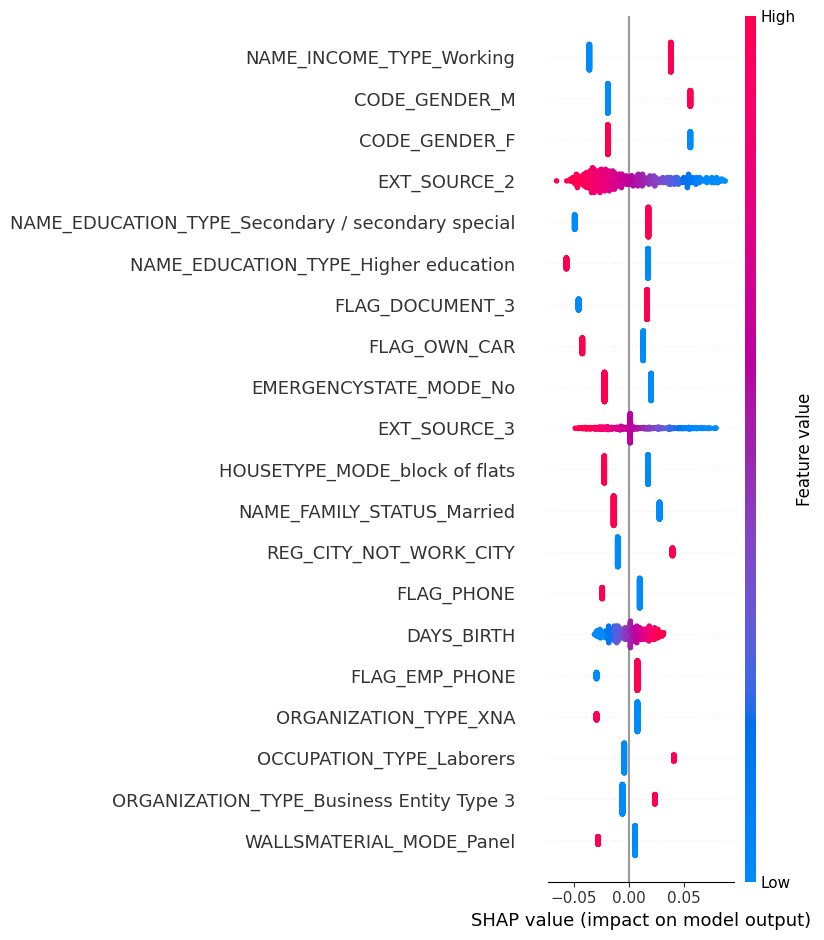

['NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Businessman']


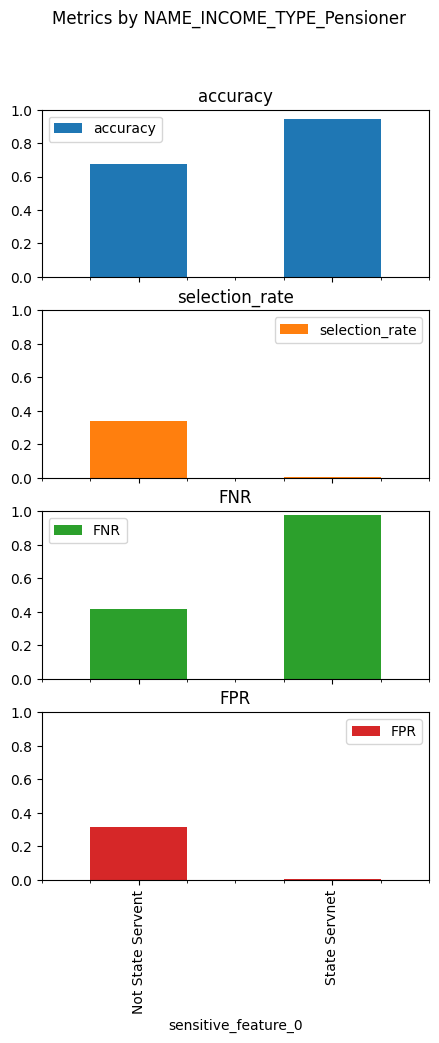

ACCURACY:  0.7239705703020203
DEMOGRAPHIC PARITY DIFFERENCE:  0.3348003657558048
DEMOGRAPHIC PARITY RATIO:  0.011474113987507396


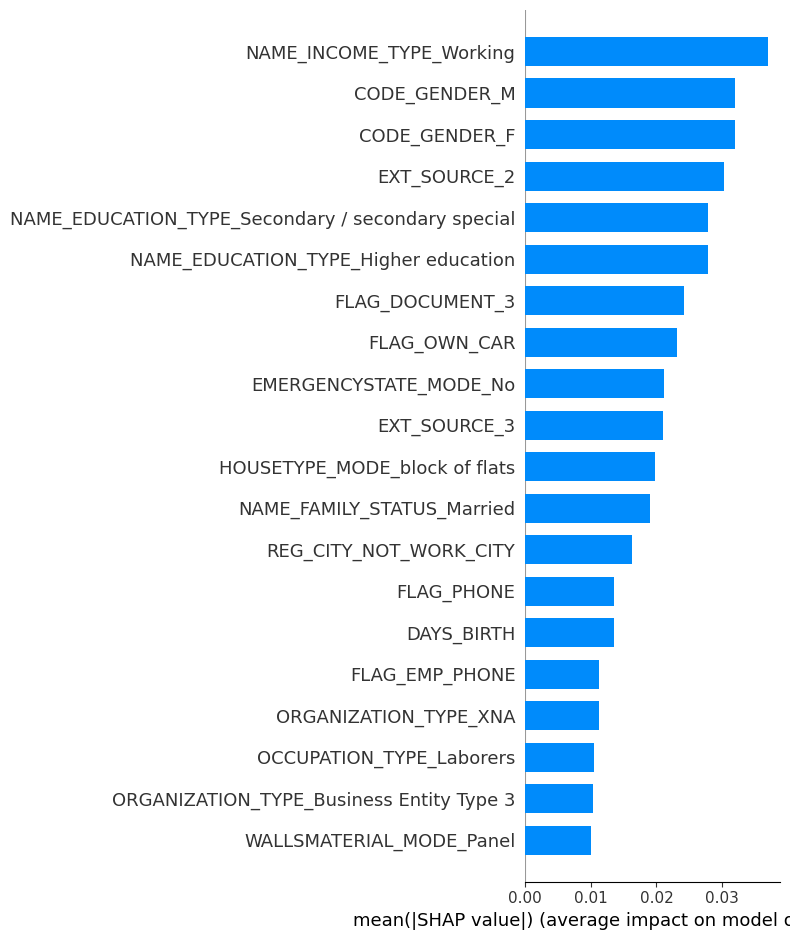

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


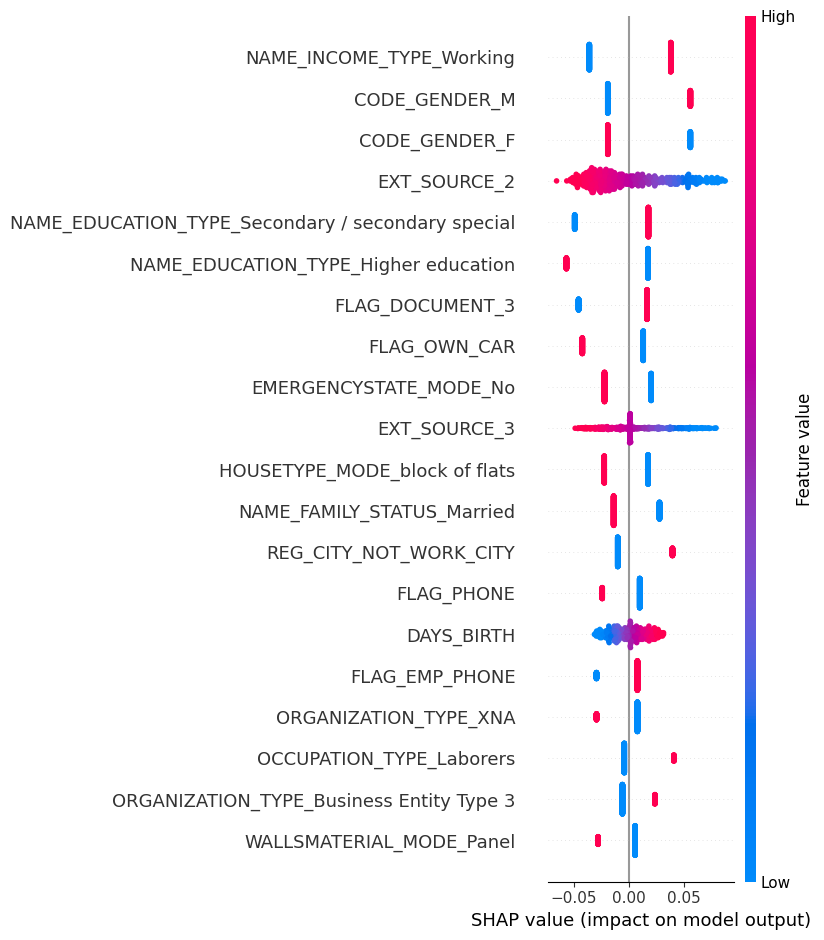

In [115]:
for category, value in Working.items():
    get_log_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])


We can see from the graphs that those who receive pensions or is a commercial associates are favored, while the working class is not favored. We now further investigate if the model is biased towards those who work a regular job, such as manual labor.

['OCCUPATION_TYPE_Laborers']


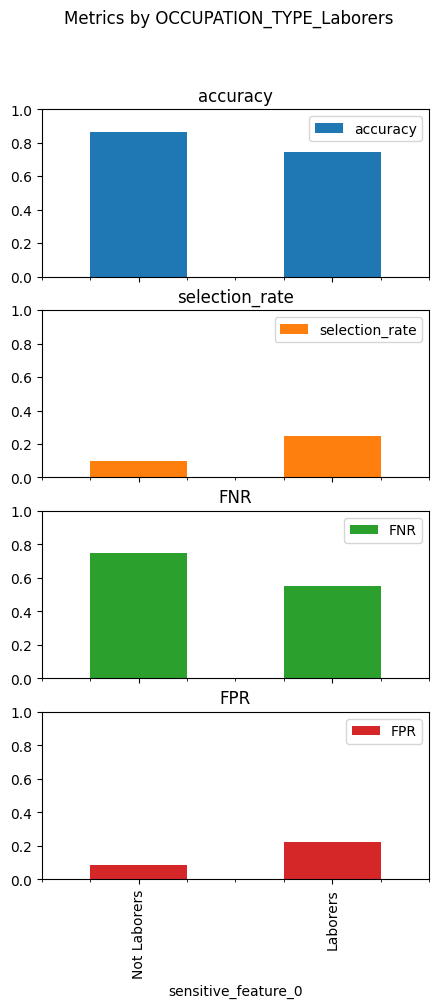

ACCURACY:  0.8431527173692126
DEMOGRAPHIC PARITY DIFFERENCE:  0.14979403352027576
DEMOGRAPHIC PARITY RATIO:  0.3938945805496398


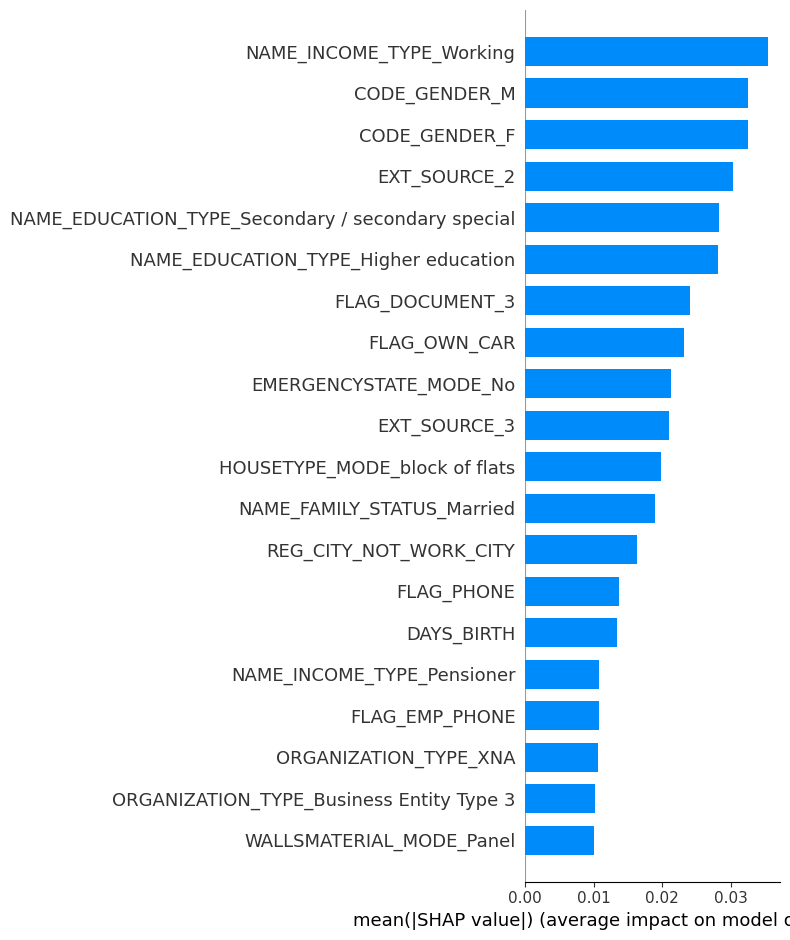

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


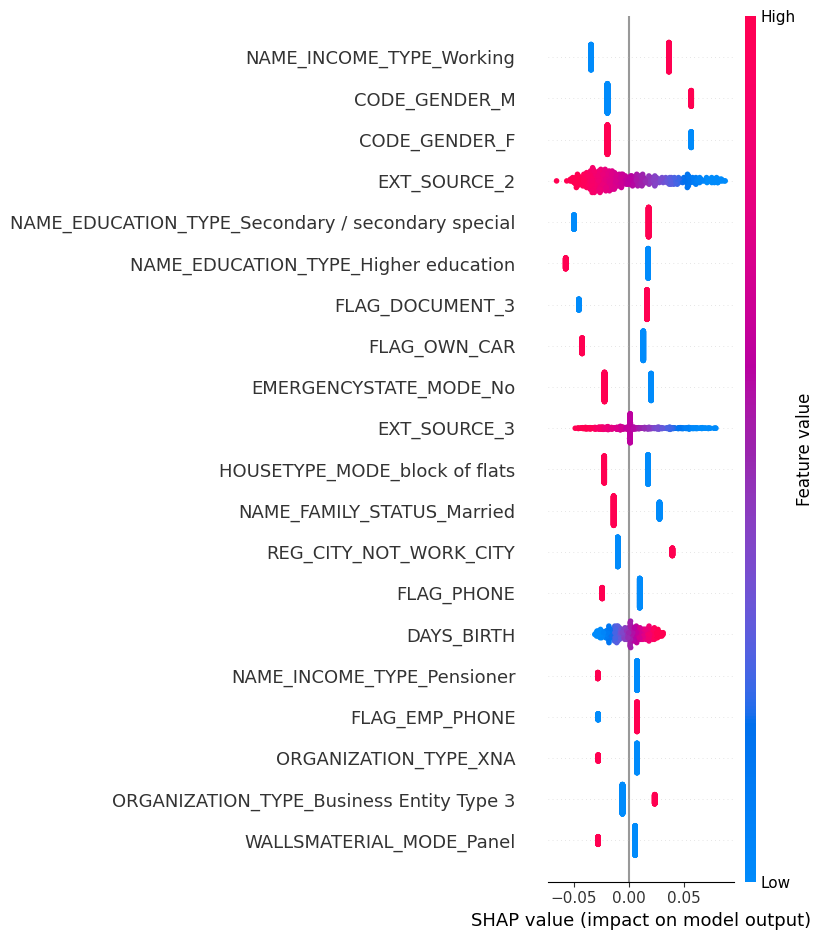

['OCCUPATION_TYPE_Low-skill Laborers']


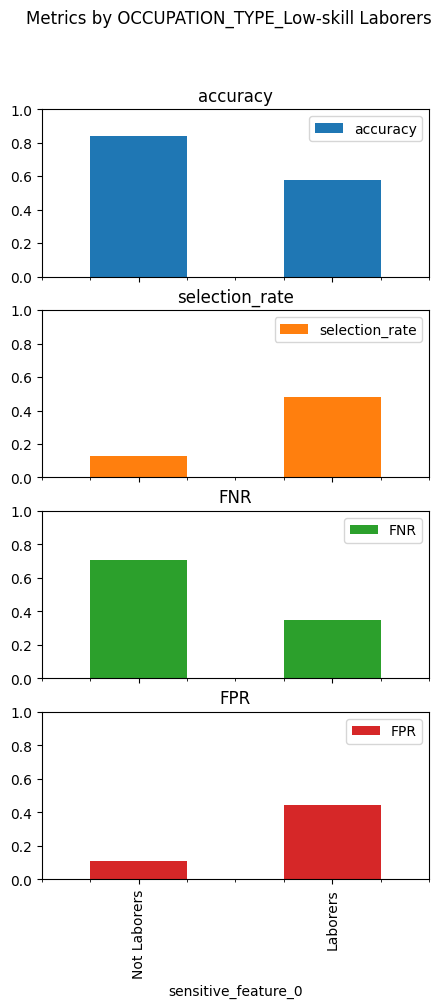

ACCURACY:  0.8397788707776107
DEMOGRAPHIC PARITY DIFFERENCE:  0.3522439338240352
DEMOGRAPHIC PARITY RATIO:  0.26301082174971196


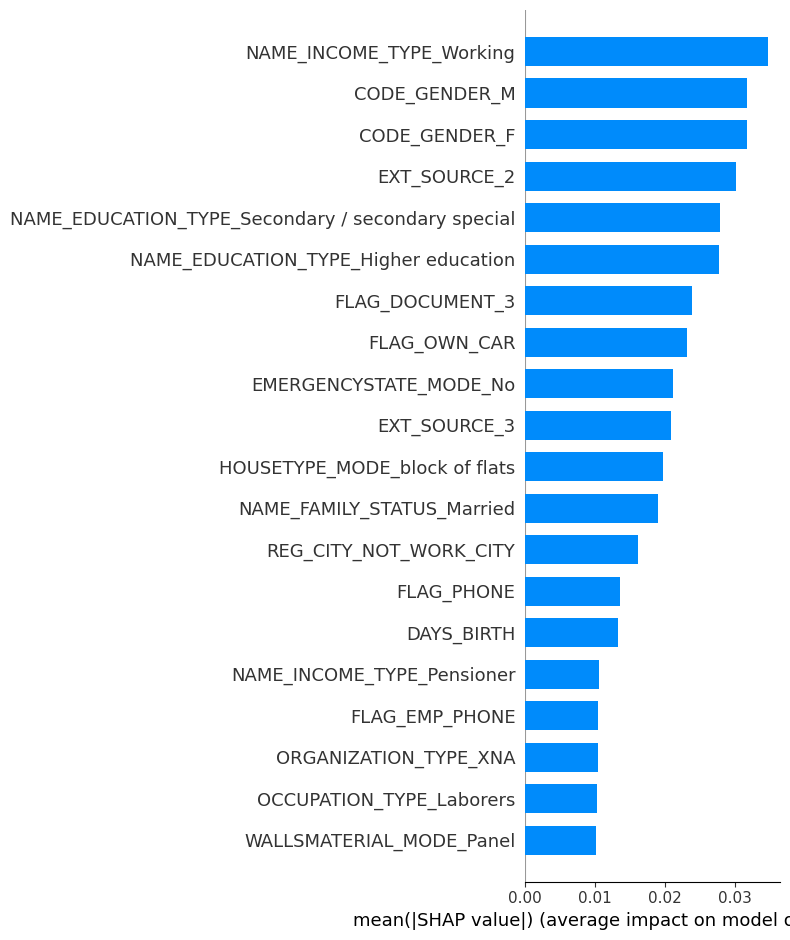

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


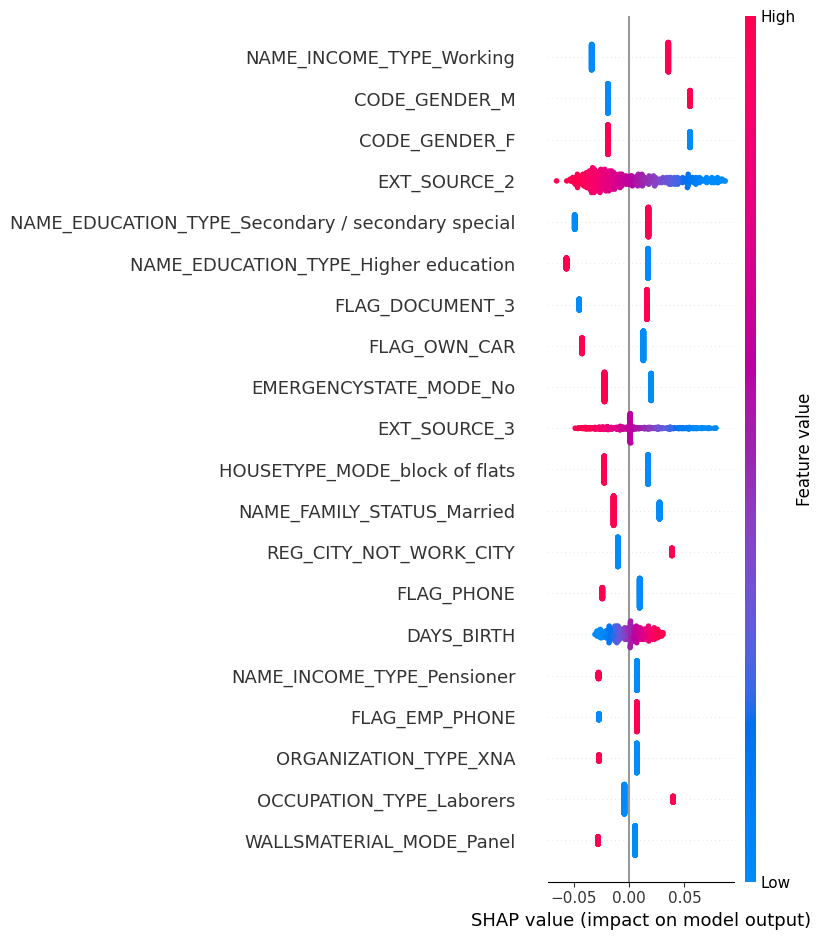

['OCCUPATION_TYPE_Managers']


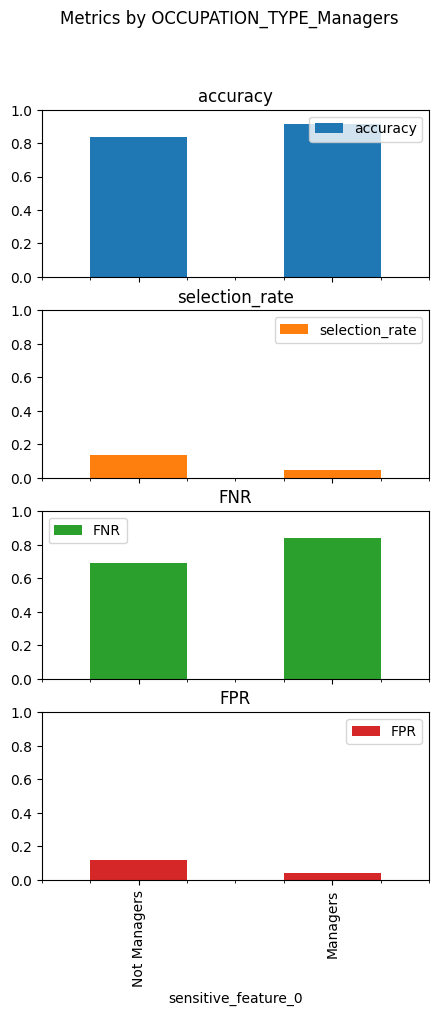

ACCURACY:  0.8398682980366652
DEMOGRAPHIC PARITY DIFFERENCE:  0.0893024754592496
DEMOGRAPHIC PARITY RATIO:  0.3338316836524285


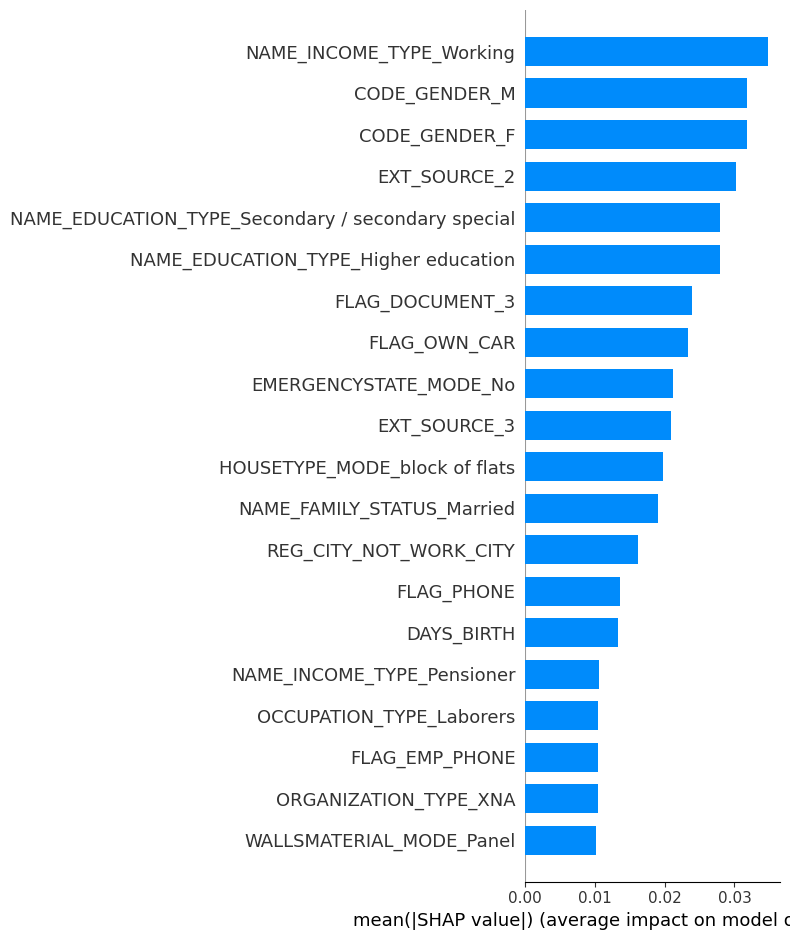

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


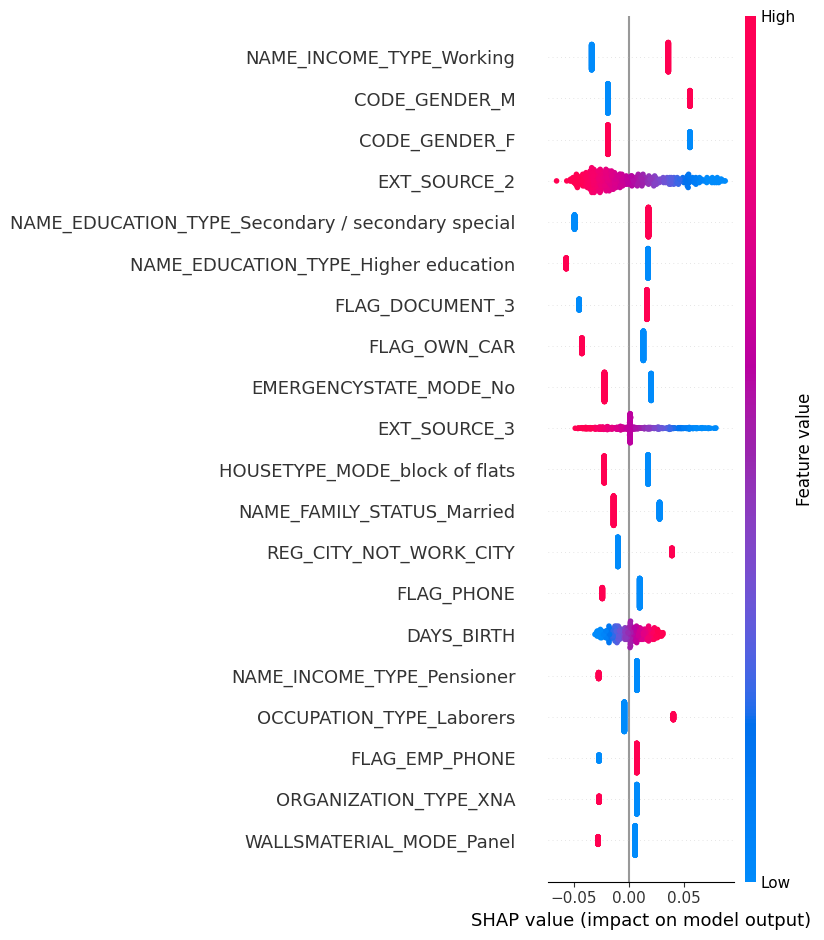

['OCCUPATION_TYPE_High skill tech staff']


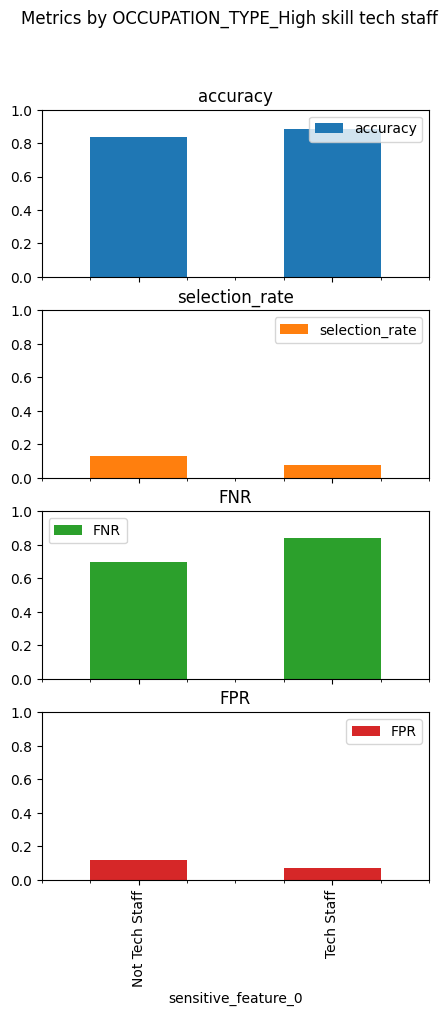

ACCURACY:  0.8398195195317264
DEMOGRAPHIC PARITY DIFFERENCE:  0.056141826790854624
DEMOGRAPHIC PARITY RATIO:  0.5682835604873795


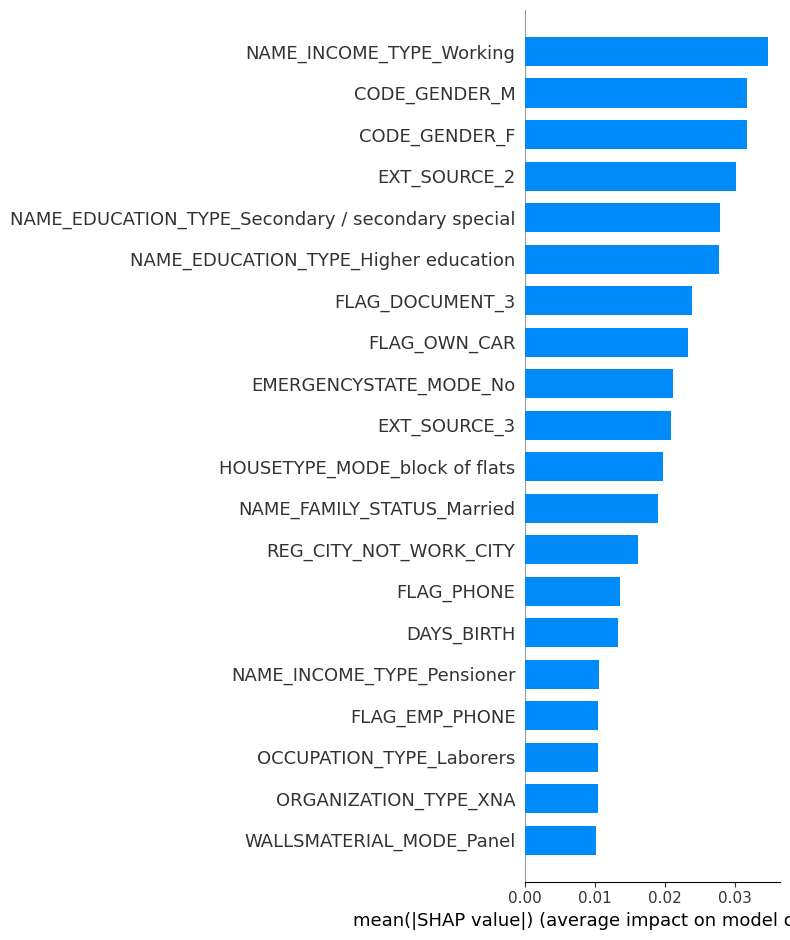

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


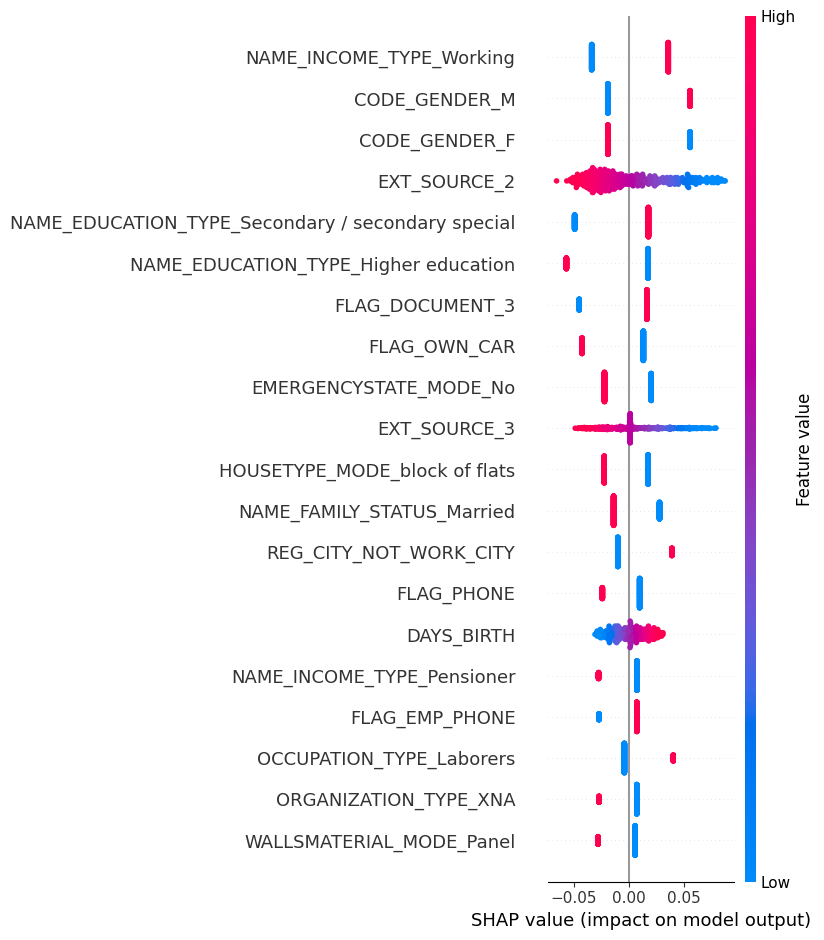

In [116]:
get_log_model_metrics(['OCCUPATION_TYPE_Laborers'], True, train, val, y_val, y_train, column_names, ['Not Laborers', 'Laborers'])
get_log_model_metrics(['OCCUPATION_TYPE_Low-skill Laborers'], True, train, val, y_val, y_train, column_names, ['Not Laborers', 'Laborers'])
get_log_model_metrics(['OCCUPATION_TYPE_Managers'], True, train, val, y_val, y_train, column_names, ['Not Managers', 'Managers'])
get_log_model_metrics(['OCCUPATION_TYPE_High skill tech staff'], True, train, val, y_val, y_train, column_names, ['Not Tech Staff', 'Tech Staff'])


The above result shows solid evidence that the model strongly favors those who work as an manager or a high-skilled IT staff, while being biased towards those who do manual labor. 

In [90]:
def get_random_forest_model_metrics(sensitiveFeature, binary, train, val, y_val, y_train, column_names, categories):
    # Store sensitive features and drop the column from train and val
    print(sensitiveFeature)
    sensitive_feature_train = train[sensitiveFeature[0]]
    sensitive_feature_val = val[sensitiveFeature[0]]

    if binary==False:
        feature_threshold = get_feature_threshold(sensitive_feature_val)
        print(feature_threshold)
        sensitive_feature_val = (sensitive_feature_val > feature_threshold).astype(int)
    else:
        label_encoder = LabelEncoder()
        label_encoder.fit(sensitive_feature_train)
        sensitive_feature_train = label_encoder.transform(sensitive_feature_train)
        sensitive_feature_val = label_encoder.transform(sensitive_feature_val)


    train = train.drop(columns=sensitiveFeature)
    val = val.drop(columns=sensitiveFeature)

    # Median imputation of missing values
    imputer = SimpleImputer(strategy='median')
    imputer.fit(train)
    train = imputer.transform(train)
    val = imputer.transform(val)

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train)
    train = scaler.transform(train)
    val = scaler.transform(val)

    # Train the logistic regression model
    random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
    y_val_pred = random_forest.fit(train, y_train)

    # Make predictions
    y_val_pred = random_forest.predict_proba(val)[:, 1]
    optimal = get_optimal_threshold(y_val, y_val_pred)
    y_val_pred = (y_val_pred > optimal).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)

    metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }
    
    grouped = MetricFrame(metrics=metrics,
                             y_true=y_val,
                             y_pred=y_val_pred,
                             sensitive_features=sensitive_feature_val)
    grouped.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by "+ sensitiveFeature[0],
    )
    plt.xticks(ticks=range(len(categories)), labels=categories)  # for x-axis categories


    plt.show()

    demo_parity_diff = demographic_parity_difference(y_val, y_val_pred, sensitive_features=sensitive_feature_val)
    demo_parity_ratio = demographic_parity_ratio(y_val, y_val_pred, sensitive_features=sensitive_feature_val)

    column_names = [col for col in column_names if (col != 'TARGET' and col != 'SK_ID_CURR' and col not in sensitiveFeature)]
    column_names

    print('ACCURACY: ', accuracy)
    print('DEMOGRAPHIC PARITY DIFFERENCE: ', demo_parity_diff)
    print('DEMOGRAPHIC PARITY RATIO: ', demo_parity_ratio)

    val = pd.DataFrame(val, columns=pd.Index(column_names))
    explainer = shap.TreeExplainer(random_forest)
    val_sample = val.sample(n=100, random_state=42)  # Select a random subset of 100 instances

    shap_values = explainer(val_sample)
    shap.summary_plot(shap_values[:, :, 1], val_sample, plot_type="bar")
    shap.summary_plot(shap_values[:, :, 1], val_sample)


['NAME_FAMILY_STATUS_Married']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


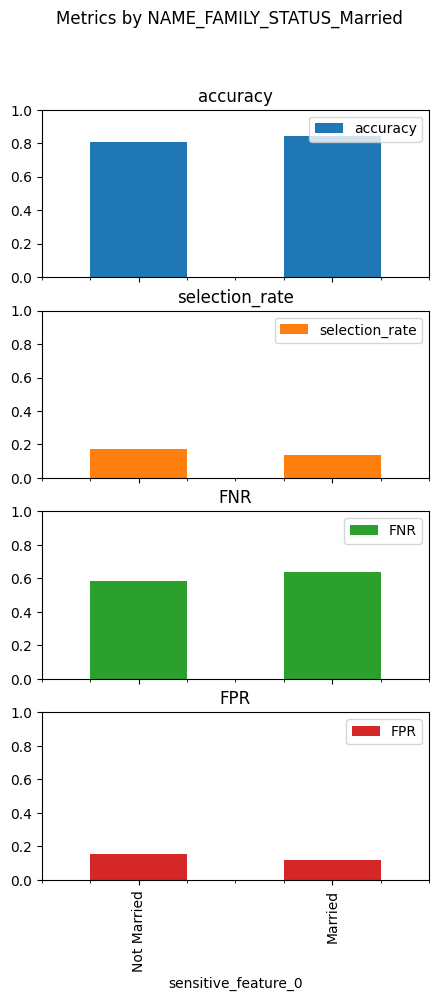

ACCURACY:  0.8309011828787448
DEMOGRAPHIC PARITY DIFFERENCE:  0.03947183556398118
DEMOGRAPHIC PARITY RATIO:  0.7755324499084764


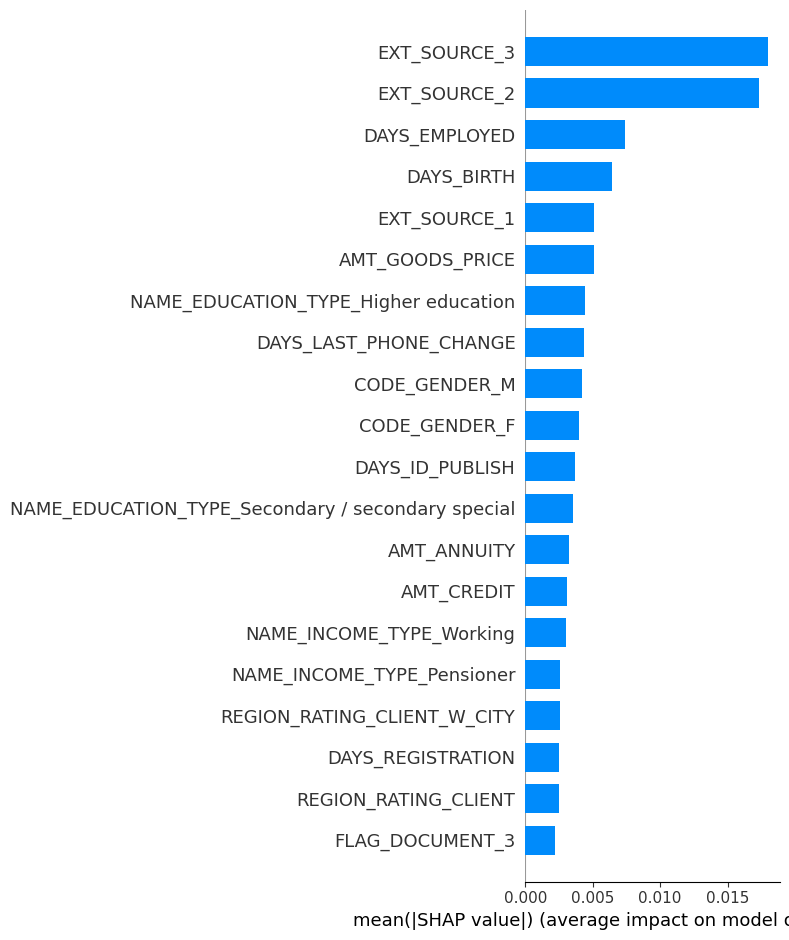

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


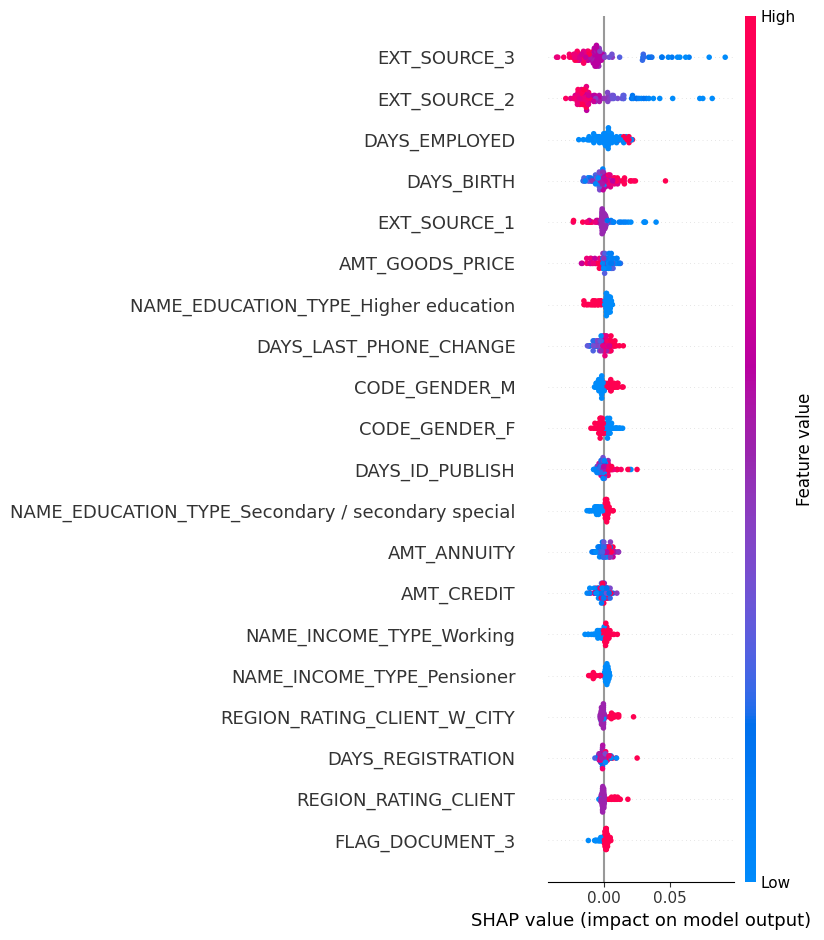

['CNT_CHILDREN']
2.5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


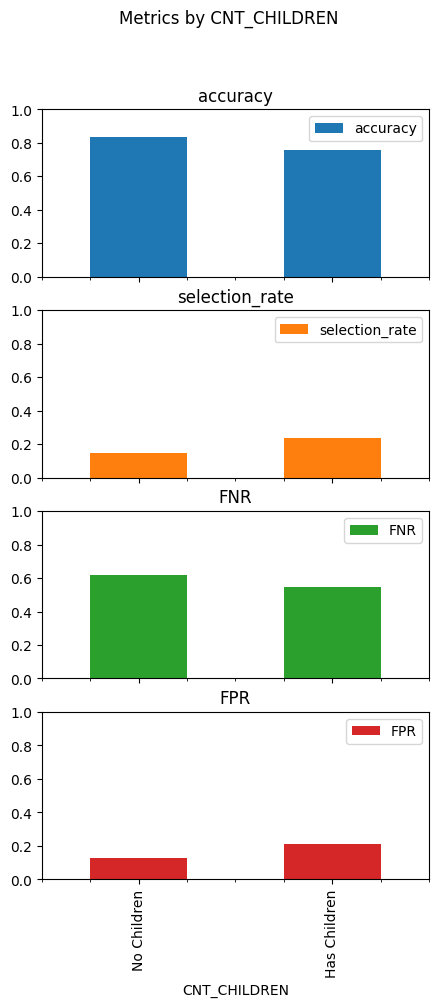

ACCURACY:  0.8312751514166091
DEMOGRAPHIC PARITY DIFFERENCE:  0.08753634152881667
DEMOGRAPHIC PARITY RATIO:  0.6295072034083014


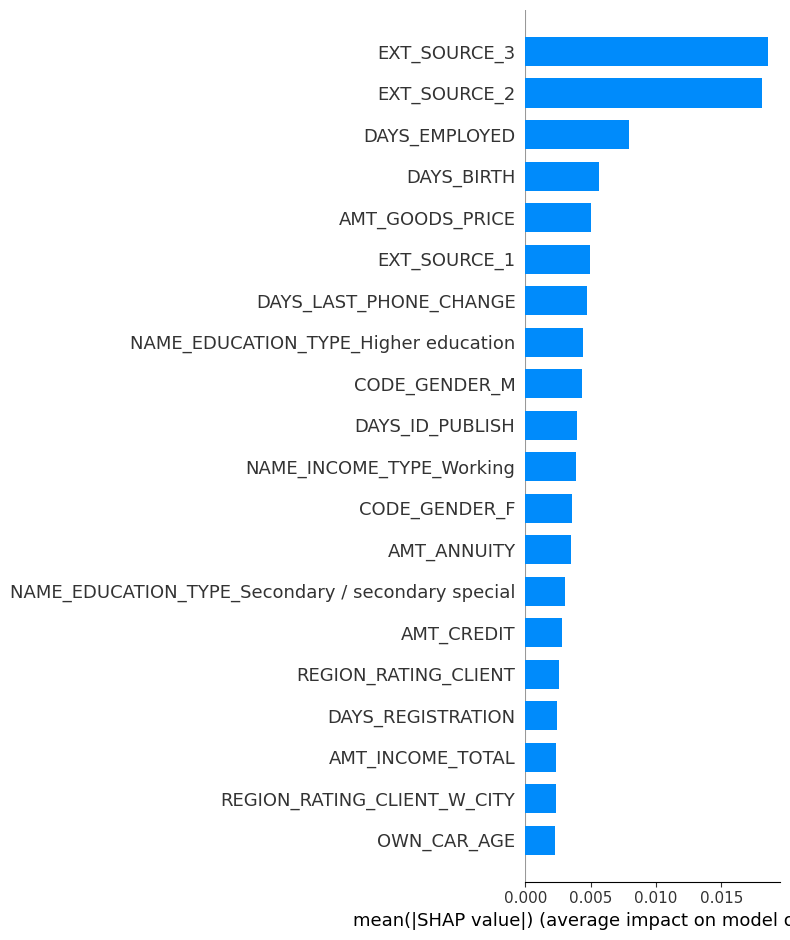

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


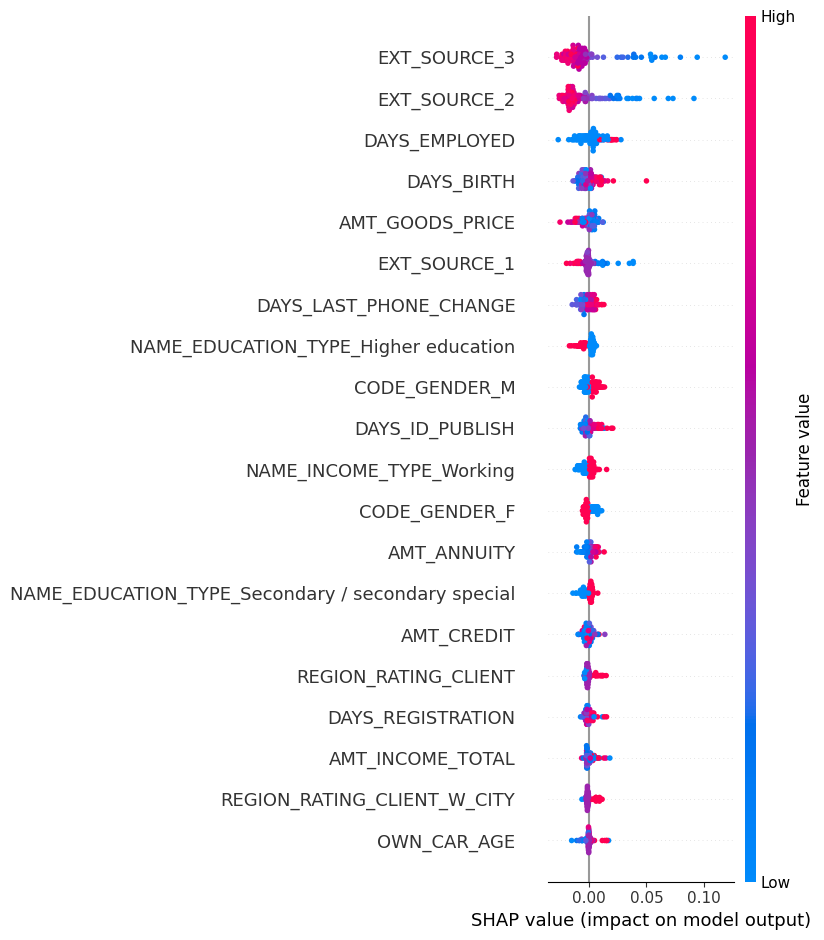

In [91]:
#run everything again but with the random forest model
for category, value in Family.items():
    get_random_forest_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])


for category, value in Children.items():
    get_random_forest_model_metrics(value[0], False, train, val, y_val, y_train, column_names, value[1]) 

['CODE_GENDER_F', 'CODE_GENDER_M']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


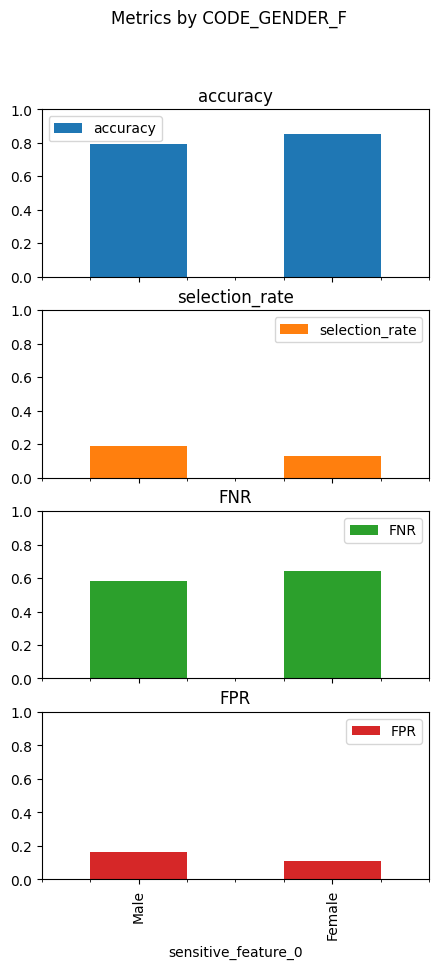

ACCURACY:  0.8326084305516036
DEMOGRAPHIC PARITY DIFFERENCE:  0.061677916065124044
DEMOGRAPHIC PARITY RATIO:  0.6745532159748777


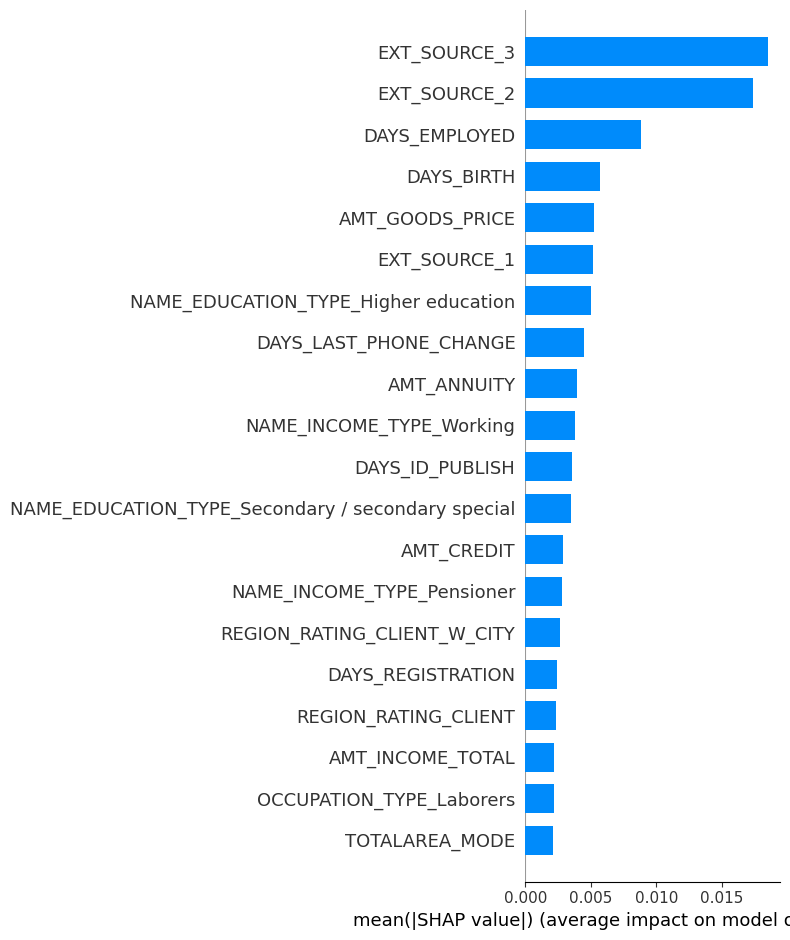

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


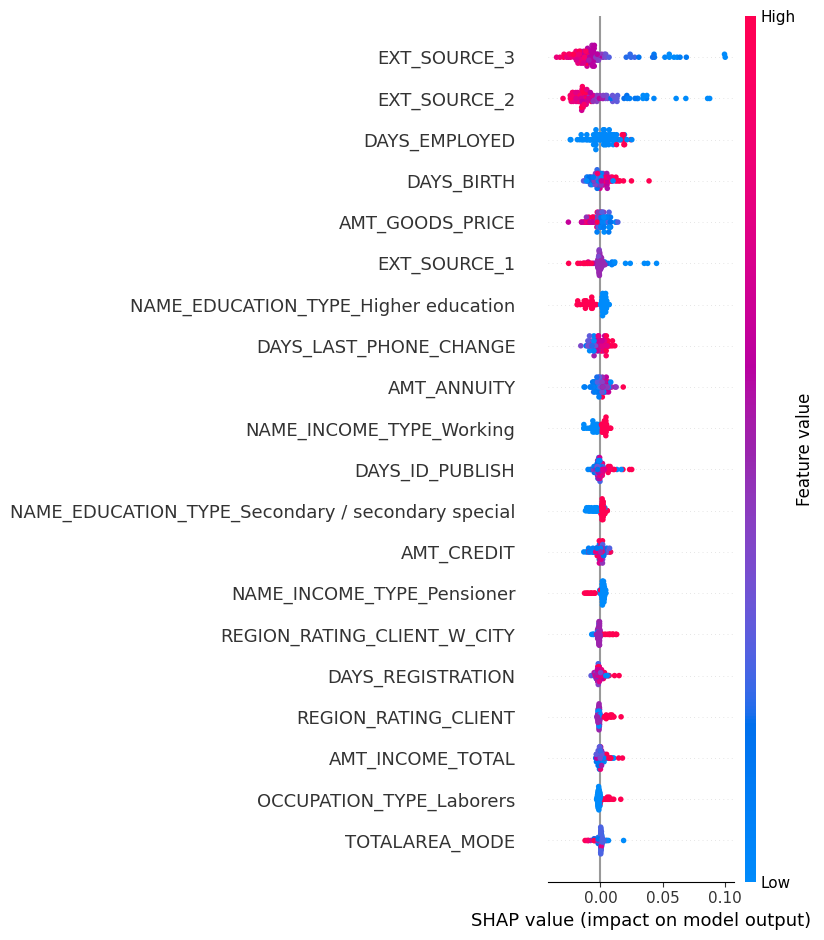

In [92]:
for category, value in Gender.items():
    get_random_forest_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

['NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Academic degree']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


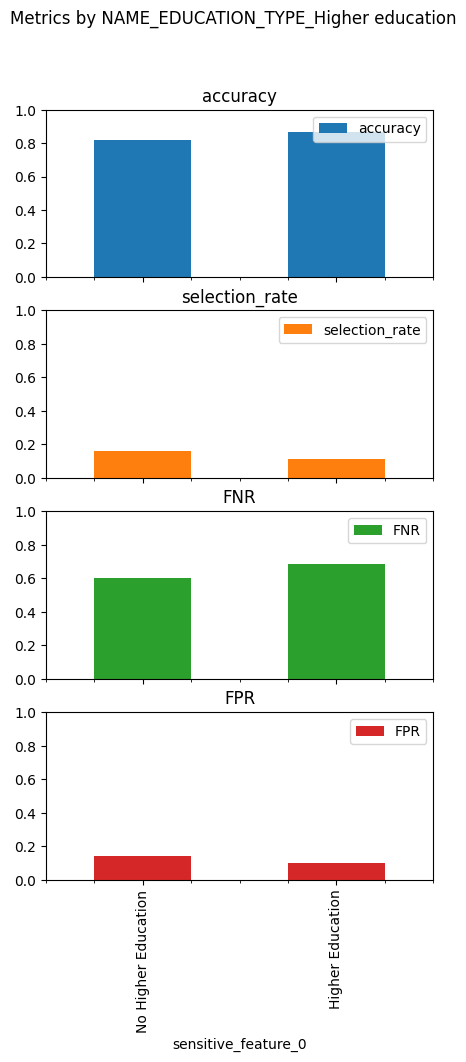

ACCURACY:  0.8314865249380107
DEMOGRAPHIC PARITY DIFFERENCE:  0.049672256595990005
DEMOGRAPHIC PARITY RATIO:  0.6935869781324634


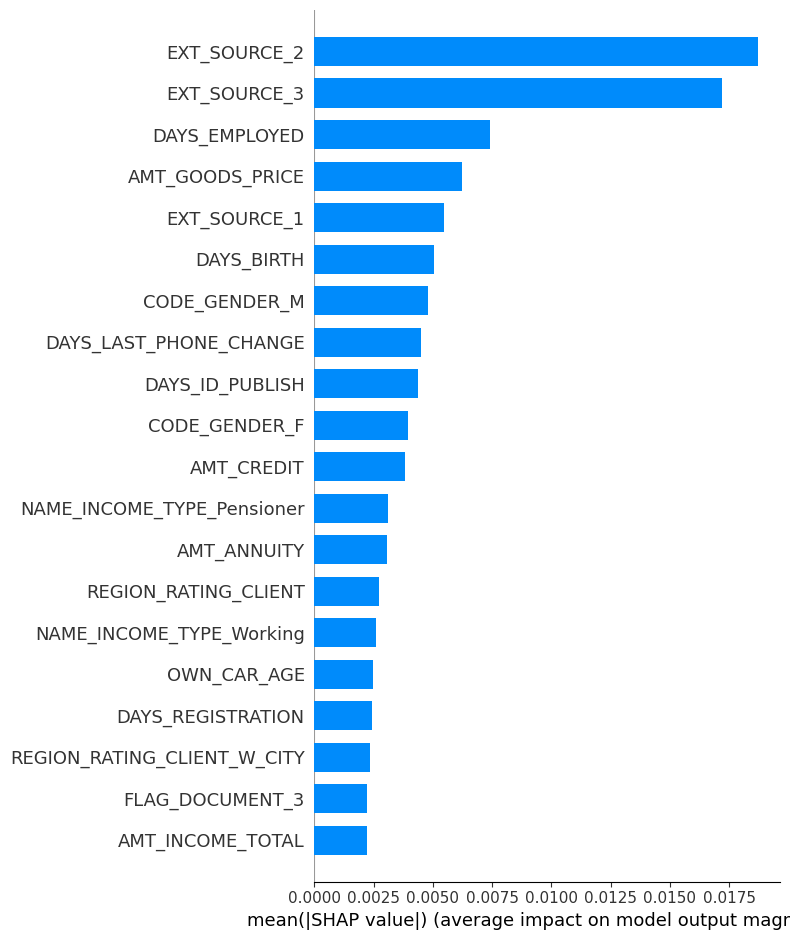

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


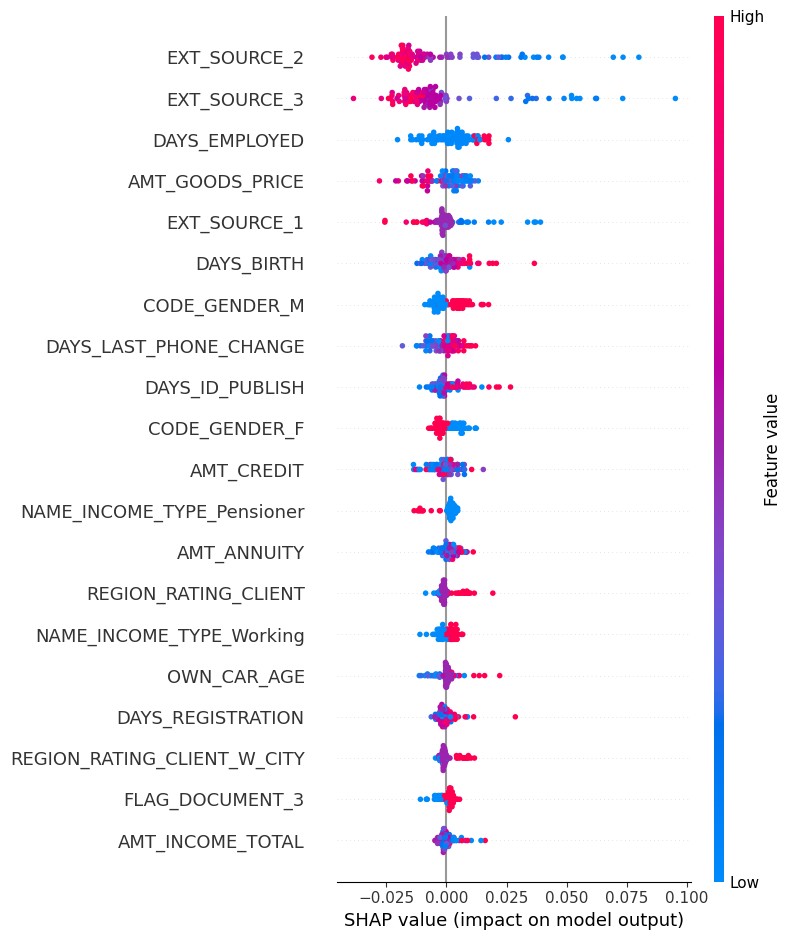

['NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Academic degree']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


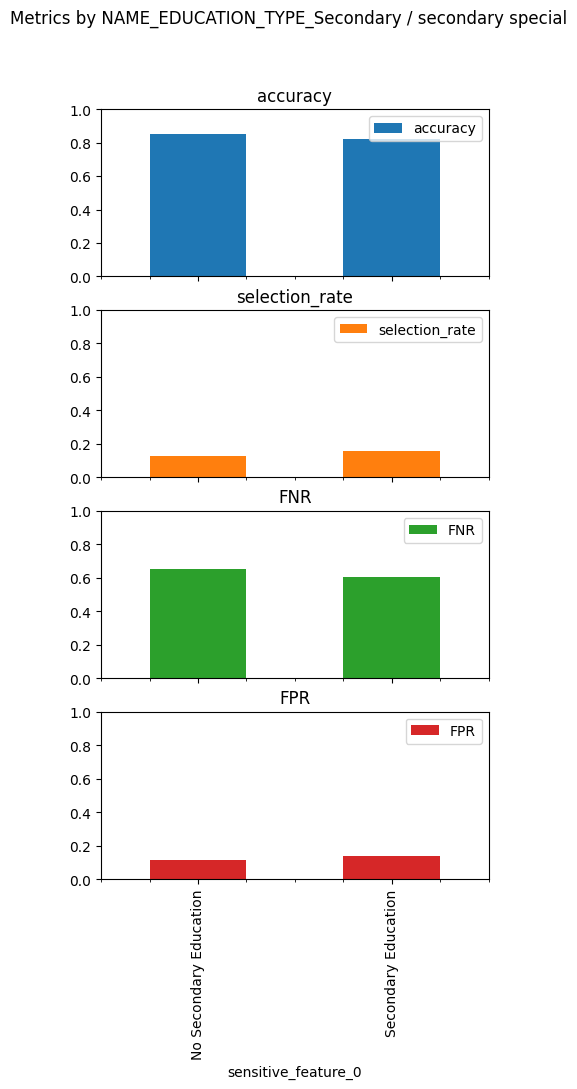

ACCURACY:  0.8314865249380107
DEMOGRAPHIC PARITY DIFFERENCE:  0.031367204490495515
DEMOGRAPHIC PARITY RATIO:  0.8029051933296507


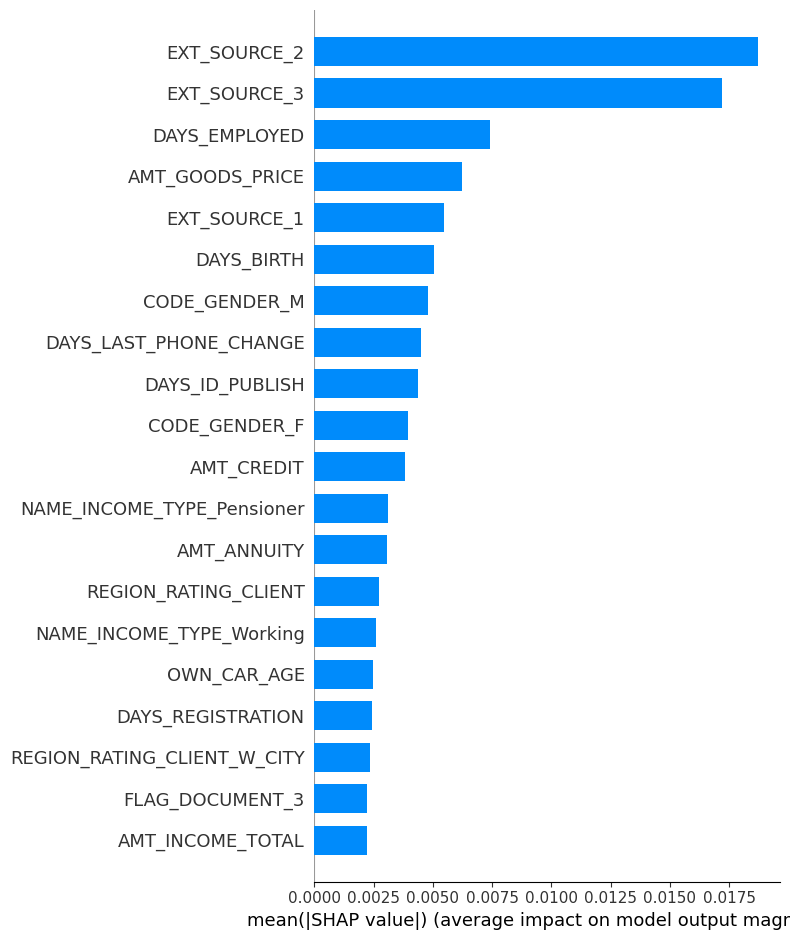

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


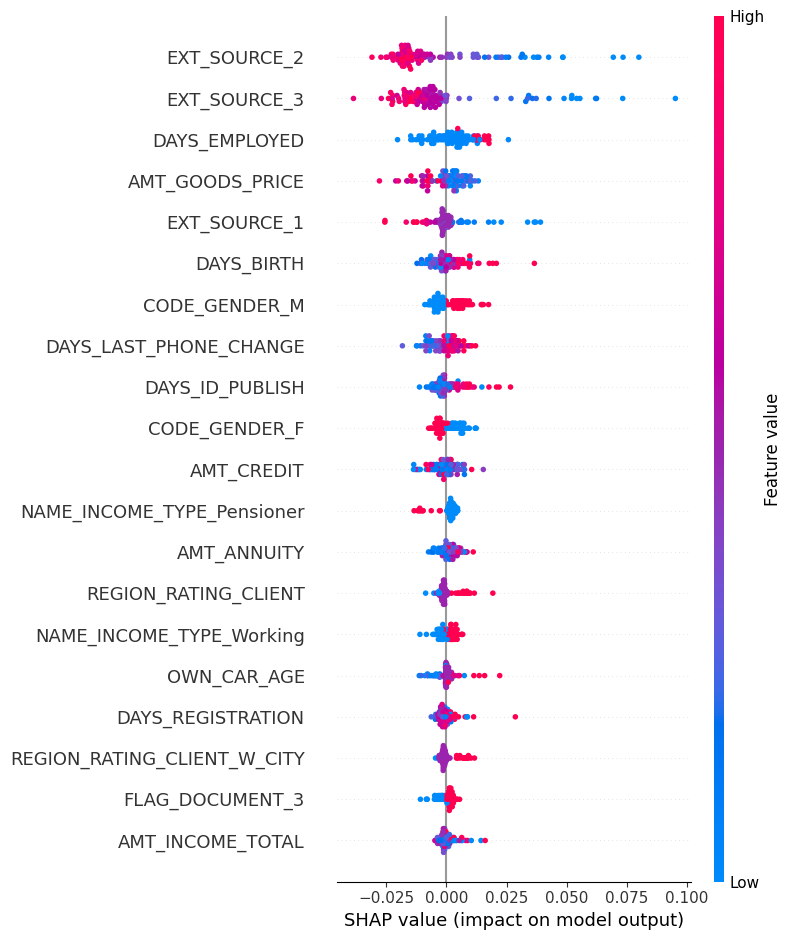

In [95]:
for category, value in Education.items():
    get_random_forest_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

['AMT_INCOME_TOTAL']
337500.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


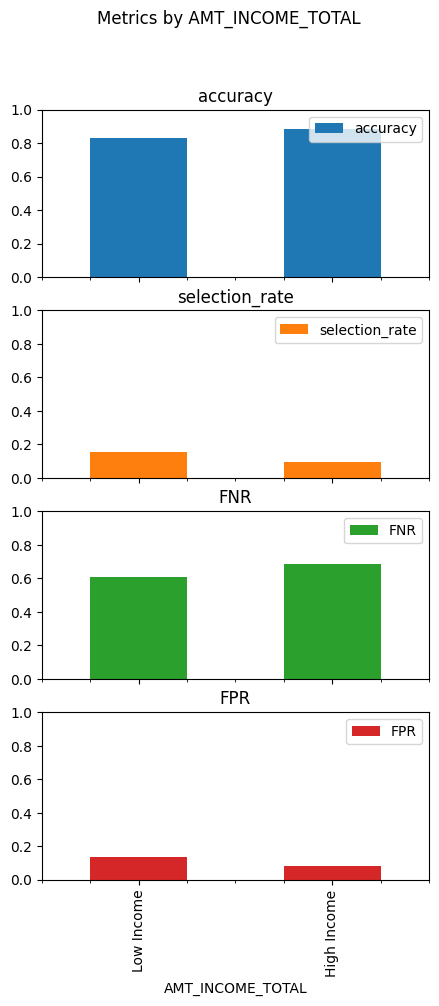

ACCURACY:  0.831332059672371
DEMOGRAPHIC PARITY DIFFERENCE:  0.05868380050451791
DEMOGRAPHIC PARITY RATIO:  0.6176238078237365


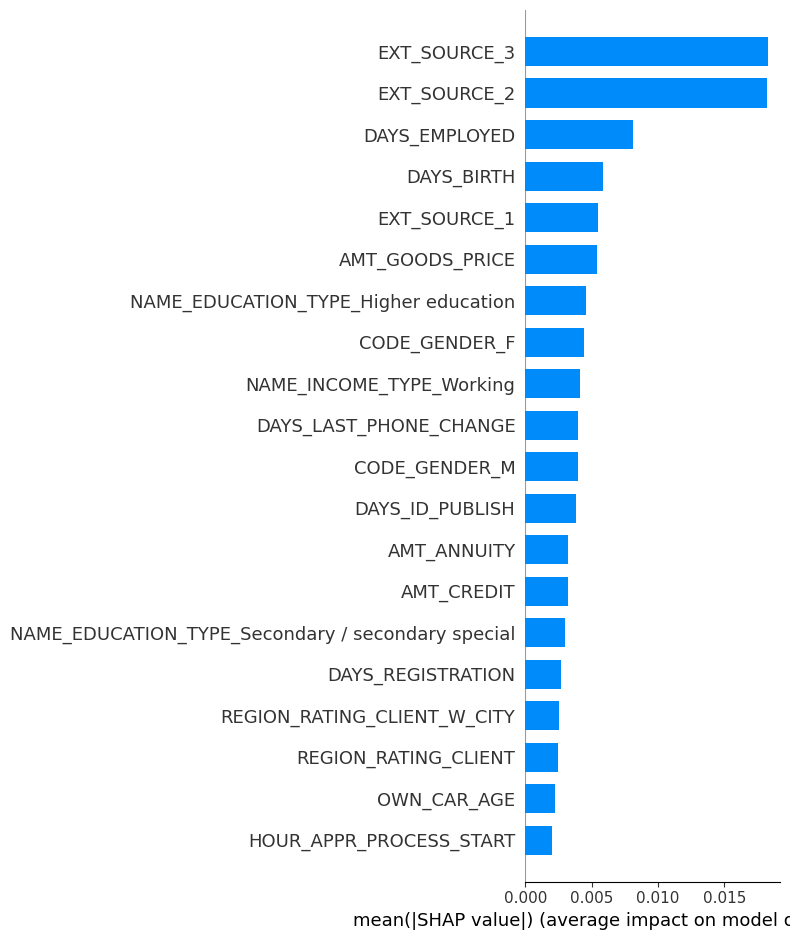

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


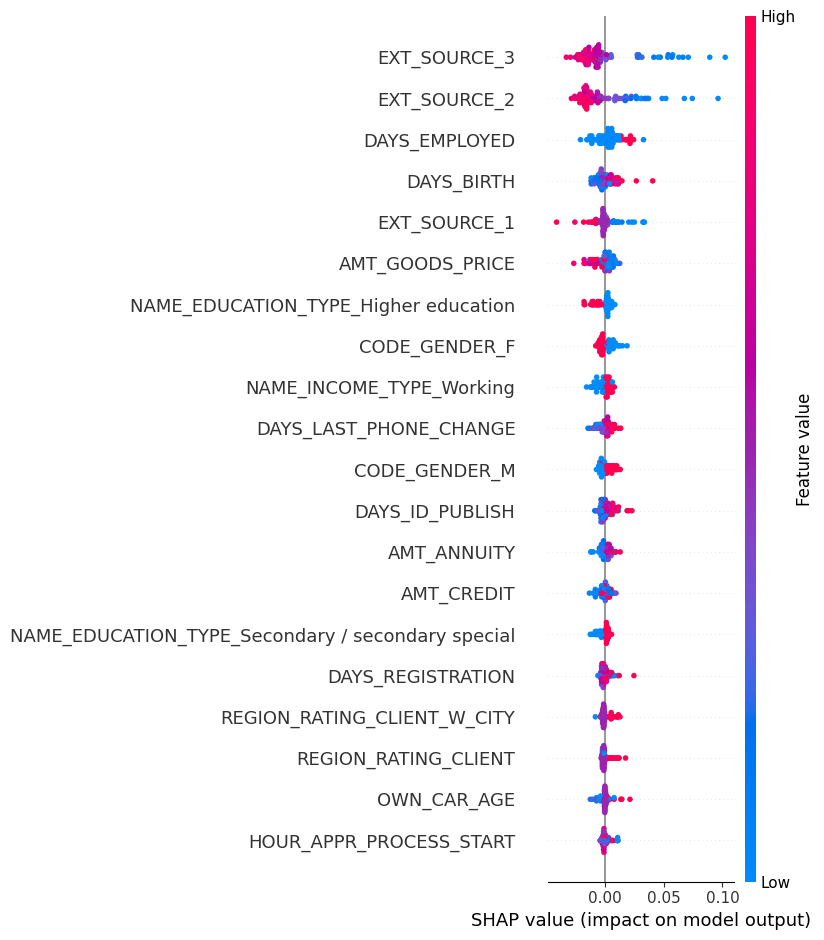

['AMT_CREDIT']
1616625.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


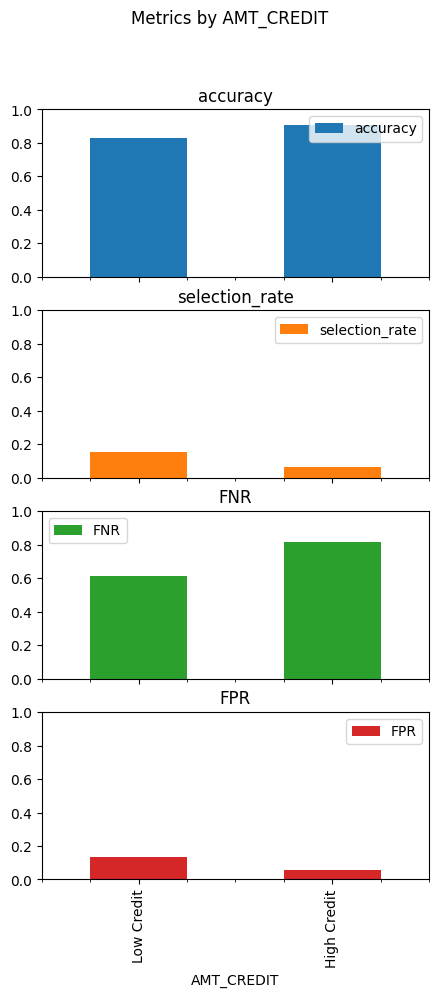

ACCURACY:  0.8296166822486891
DEMOGRAPHIC PARITY DIFFERENCE:  0.09078617739238422
DEMOGRAPHIC PARITY RATIO:  0.40994131025796343


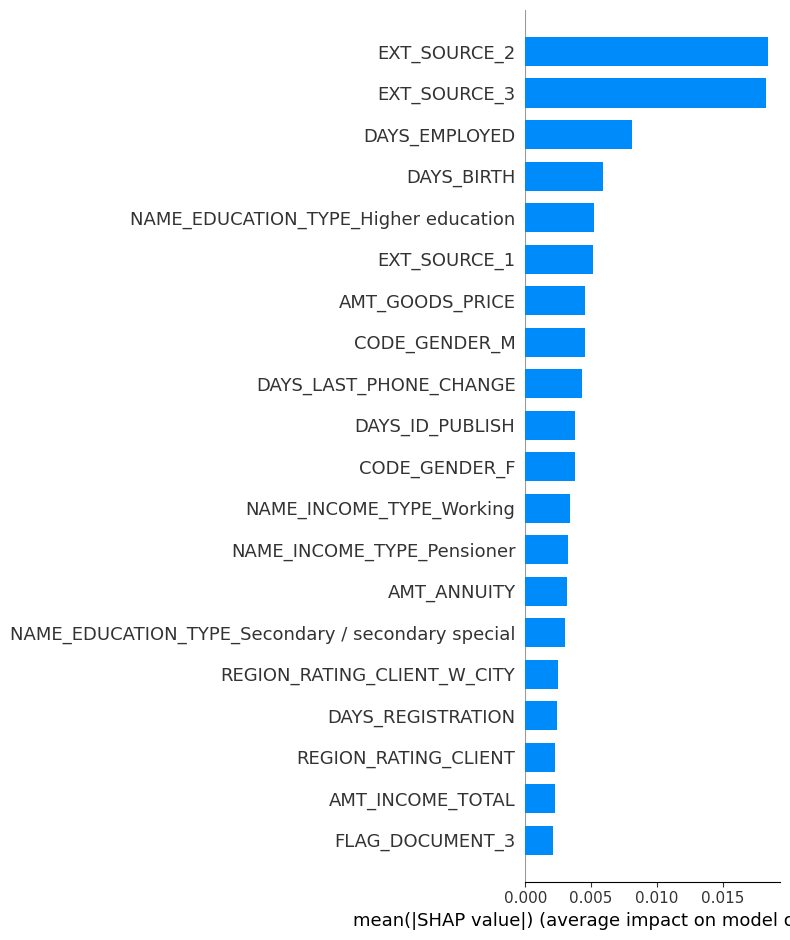

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


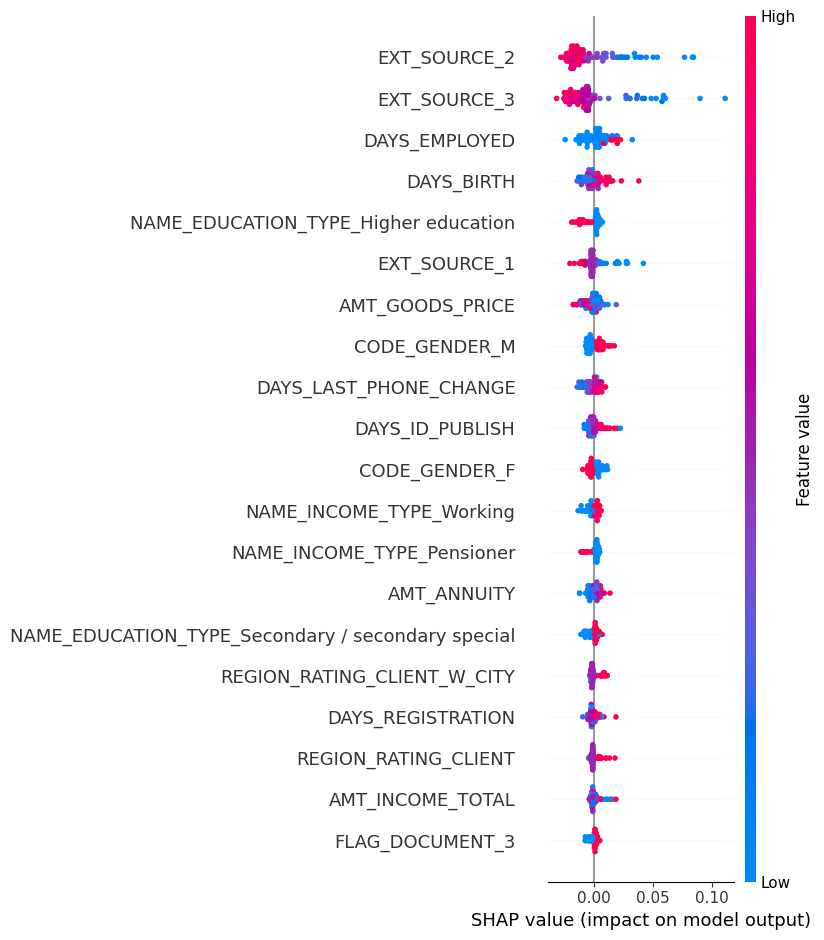

['FLAG_OWN_CAR']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


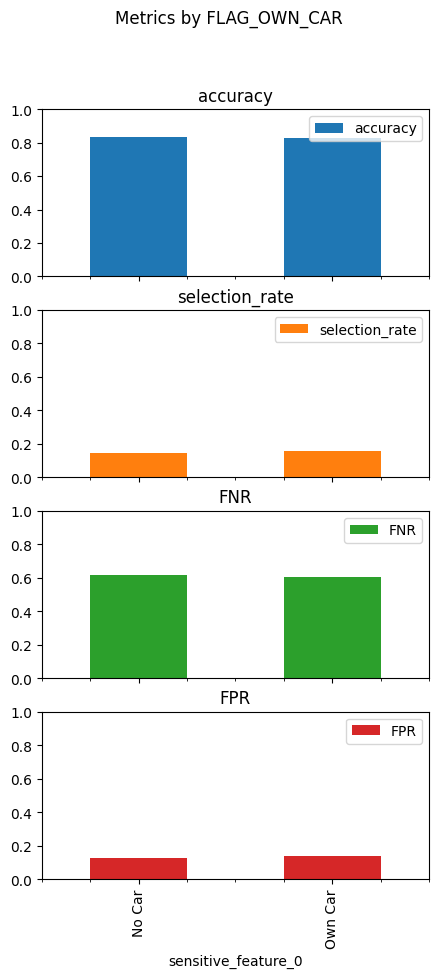

ACCURACY:  0.8314052274297793
DEMOGRAPHIC PARITY DIFFERENCE:  0.00790369383174147
DEMOGRAPHIC PARITY RATIO:  0.949279243380746


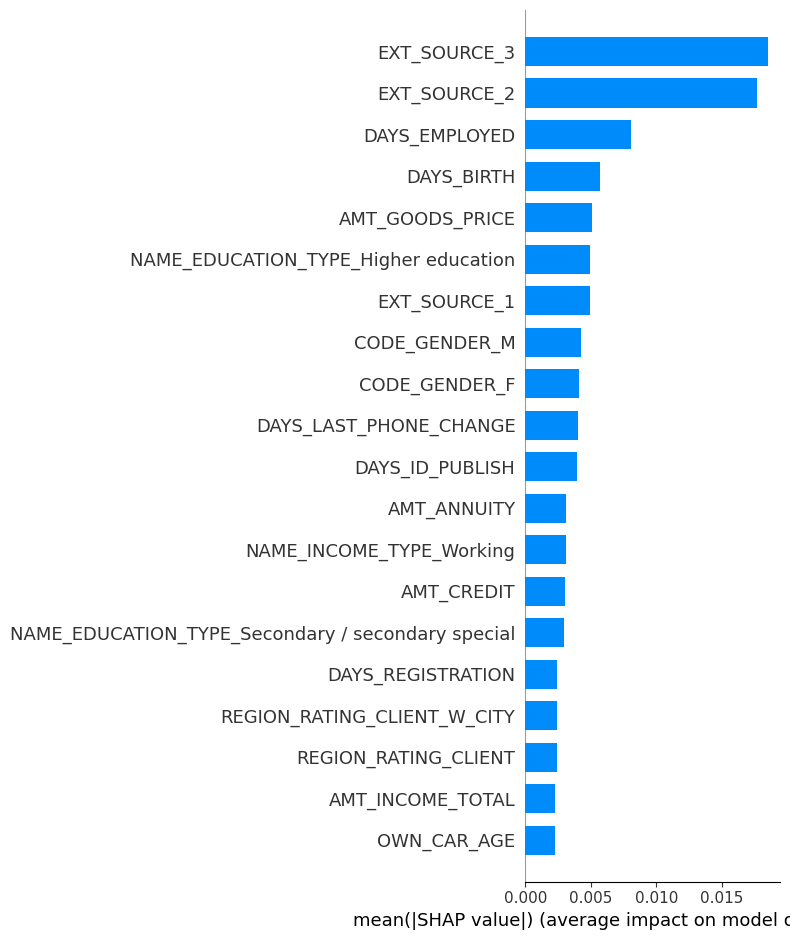

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


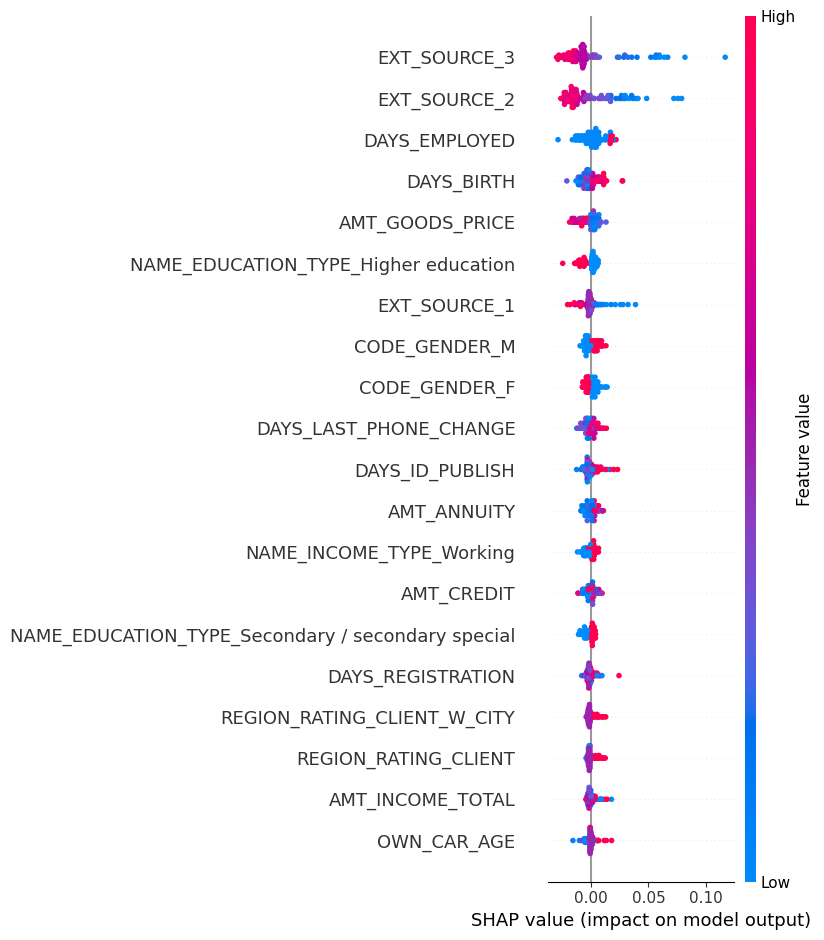

['FLAG_OWN_REALTY']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


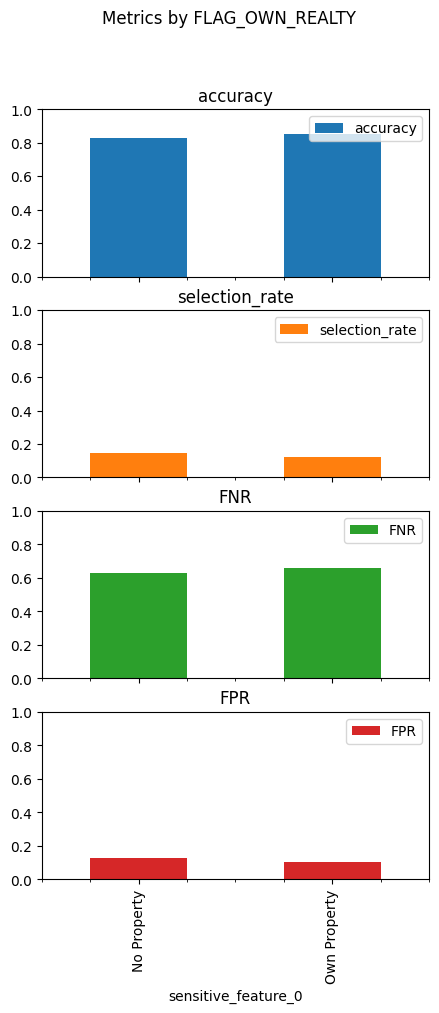

ACCURACY:  0.8460225194097801
DEMOGRAPHIC PARITY DIFFERENCE:  0.027242303009735055
DEMOGRAPHIC PARITY RATIO:  0.8169406003174418


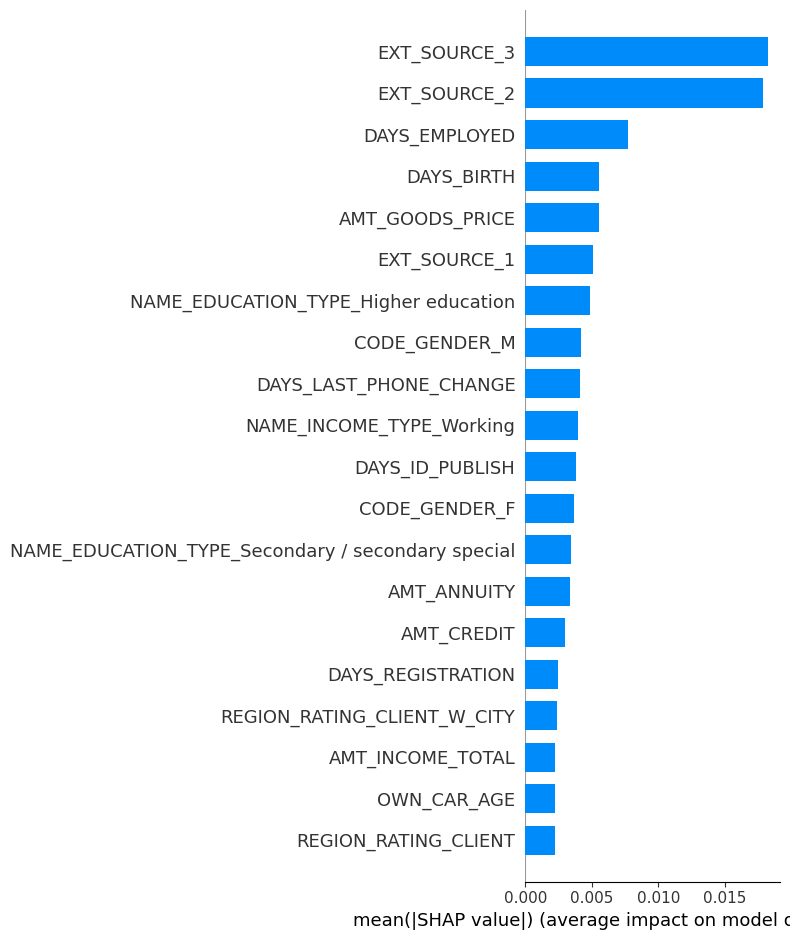

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


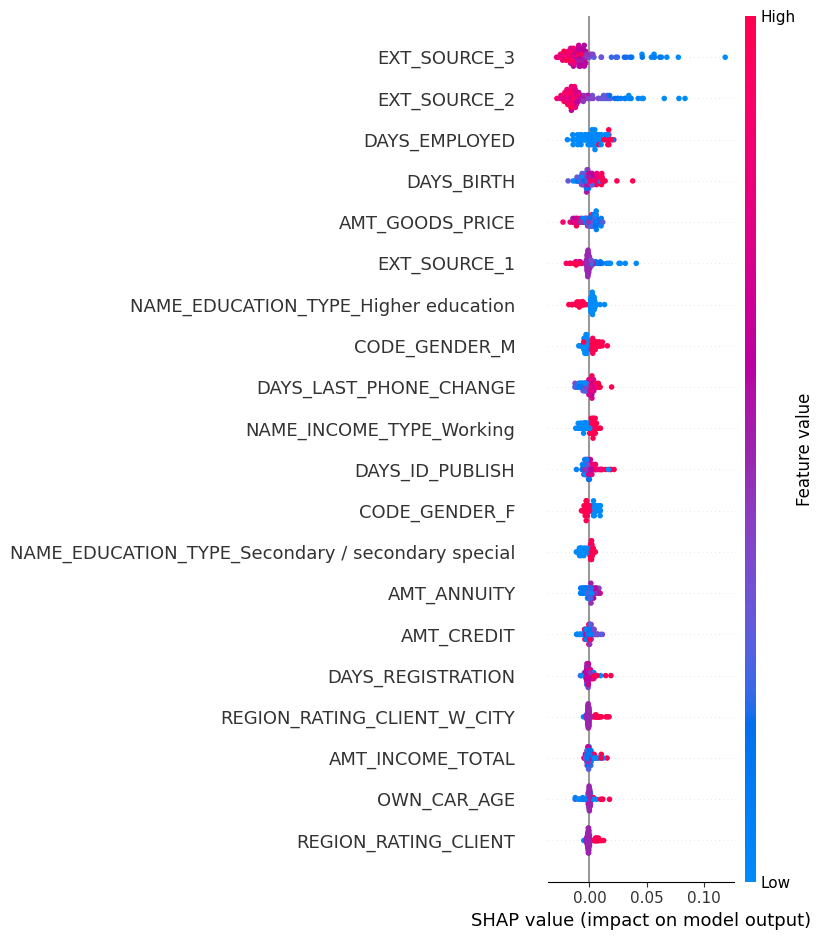

In [96]:
for category, value in Credit.items():
    get_random_forest_model_metrics(value[0], False, train, val, y_val, y_train, column_names, value[1])

for category, value in Ownership.items():
    get_random_forest_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])

We find that those with who request a higher amount loan is more likely to be rejected for a loan using this model, and those with low income are also more likely to be rejected. The model also have a higher accuracy on high-credit amount loans.  
Property ownership, on the other hand, has a higher demographic parity ratio. This means that the model is less biased towards property ownership, this is evident on both car ownership and real estate ownership.

Overall, the random forest model and logistic regression model performed similarll, with the random forest model having slightly higher accuracy overall. 

In [ ]:
for category, value in Working.items():
    get_random_forest_model_metrics(value[0], True, train, val, y_val, y_train, column_names, value[1])